# Fact Checking

*Notebook by Michele Luca Contalbo*  
*some materials are taken from Zhijiang Guo, Michael Schlichtkrull, and Andreas Vlachos. 2022. A Survey on Automated Fact-Checking. Transactions of the Association for Computational Linguistics, 10:178–206.​*


**Fact-checking** is the task of assessing whether claims made in written or spoken language are **true**. It is  
1. an **essential task for journalism**, often conducted manually, to promote truthful reporting;
2. **time consuming**, as fact given a claim, fact checkers need to search through potentially many sources;
3. **can be automated** with a certain accuracy.

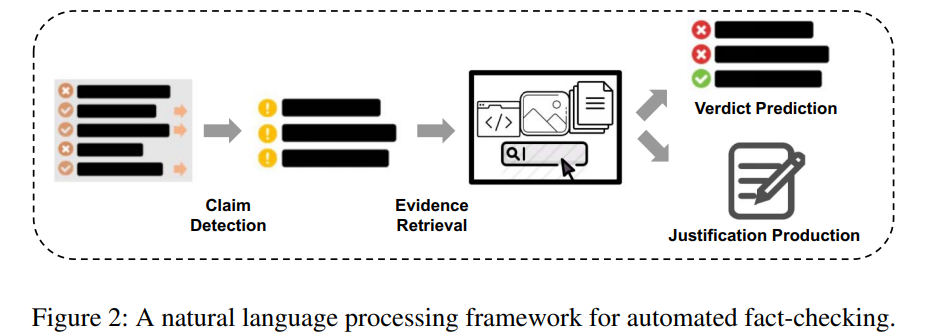  

The NLP framework for Fact-Checking consists of:  
1. **claim detection** to identify claims that require verification. This is a classification task (*"checkable"* or *"not checkable"*) done with models trained mainly in a supervised manner;
2. **evidence retrieval** to find sources supporting or refuting the claim;
3. **claim verification** to assess the veracity of the claim based on the retrieved evidence, which can be decomposed to:
  i. **verdict prediction**, where claims are assigned truthfulness labels;
  ii. **justification production**, where explanations for verdicts must be produced. This task is often performed via attention-based explanations, post-hoc explainability methods like LIME / SHAP, knowledge-based methodologies via knowledge graphs, or through natural language generation (i.e. LLMs)

In this notebook, we will tackle the **evidence retrieval** and **verdict prediction** phases.


In [1]:
!pip install transformers
!pip install torch

In [2]:
import torch
import json
import os
import pandas as pd
import torch.nn.functional as F

from tqdm import tqdm
from functools import lru_cache
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader

In [3]:
# util function

@lru_cache(maxsize=None)
def get_device():
    device = torch.device("cpu")
    if torch.cuda.is_available():
        device = torch.device("cuda:0")

    return device

# Loading of FEVER dataset

In [4]:
%mkdir -p fever_data
%cd fever_data
!wget -O train.jsonl https://fever.ai/download/fever/train.jsonl
!wget -O wiki-pages.zip https://fever.ai/download/fever/wiki-pages.zip
!unzip wiki-pages.zip -d wiki-pages
!mv train.jsonl wiki-pages/wiki-pages/
%cd wiki-pages/wiki-pages/
%ls

/content/fever_data
--2025-12-14 11:00:45--  https://fever.ai/download/fever/train.jsonl
Resolving fever.ai (fever.ai)... 52.85.12.77, 52.85.12.88, 52.85.12.16, ...
Connecting to fever.ai (fever.ai)|52.85.12.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33024303 (31M) [application/x-www-form-urlencoded]
Saving to: ‘train.jsonl’

train.jsonl         100%[===================>]  31.49M  --.-KB/s    in 0.1s    

2025-12-14 11:00:45 (214 MB/s) - ‘train.jsonl’ saved [33024303/33024303]

--2025-12-14 11:00:45--  https://fever.ai/download/fever/wiki-pages.zip
Resolving fever.ai (fever.ai)... 52.85.12.77, 52.85.12.88, 52.85.12.16, ...
Connecting to fever.ai (fever.ai)|52.85.12.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1713485474 (1.6G) [application/zip]
Saving to: ‘wiki-pages.zip’

wiki-pages.zip      100%[===================>]   1.60G  96.6MB/s    in 9.7s    

2025-12-14 11:00:56 (169 MB/s) - ‘wiki-pages.zip’ saved [1713485474/1

In [5]:
def is_float(num):
    """
    Check if a string is a float.
    """
    try:
        float(num)
        return True
    except:
        return False

"""
set_of_evidence is where we store all the pieces of evidence in the format
{
    "wikipedia_page_id": {
        "sentence_number": "text"
    }
}
"""

set_of_evidences = {}
for i in tqdm(range(109), desc="Iterating over the files..."): # we extract the evidence only from file 001 to 020 to be quicker
    number_in_string = str(i+1)
    if len(number_in_string) == 1:
        number_in_string = "00" + number_in_string
    elif len(number_in_string) == 2:
        number_in_string = "0" + number_in_string
    filename = f"wiki-{number_in_string}.jsonl"
    if not filename.endswith(".jsonl"):
        continue
    print(f"Extracting from file {filename}...")
    with open(filename, "r") as reader:
        for line in tqdm(reader, desc="Iterating over the lines..."):
            if not line.strip().split():
                continue
            data = json.loads(line)
            sent_num = data["lines"].split("\t")[0].strip()
            if len(sent_num) == 0:
                continue
            if not is_float(sent_num):
                raise ValueError(f"Non-float sentence number: {sent_num}")
            if data["id"] not in set_of_evidences.keys():
                set_of_evidences[data["id"]] = {}
            if sent_num in set_of_evidences[data["id"]].keys():
                raise ValueError(f"Sentence number {sent_num} is already inside the evidences for the {data['id']} sample")
            set_of_evidences[data["id"]][sent_num] = data["text"]

Iterating over the files...:   0%|          | 0/109 [00:00<?, ?it/s]

Extracting from file wiki-001.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 3930it [00:00, 39283.09it/s]
Iterating over the lines...: 8317it [00:00, 41978.70it/s]
Iterating over the lines...: 12515it [00:00, 40860.81it/s]
Iterating over the lines...: 16871it [00:00, 41904.10it/s]
Iterating over the lines...: 21201it [00:00, 42397.07it/s]
Iterating over the lines...: 25530it [00:00, 42697.70it/s]
Iterating over the lines...: 29802it [00:00, 41510.98it/s]
Iterating over the lines...: 34098it [00:00, 41960.46it/s]
Iterating over the lines...: 38301it [00:00, 41272.72it/s]
Iterating over the lines...: 42497it [00:01, 41475.03it/s]
Iterating over the lines...: 50000it [00:01, 40613.07it/s]
Iterating over the files...:   1%|          | 1/109 [00:01<02:13,  1.23s/it]

Extracting from file wiki-002.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4143it [00:00, 41427.67it/s]
Iterating over the lines...: 10450it [00:00, 54136.93it/s]
Iterating over the lines...: 16570it [00:00, 57358.13it/s]
Iterating over the lines...: 22730it [00:00, 59030.62it/s]
Iterating over the lines...: 28634it [00:00, 57334.45it/s]
Iterating over the lines...: 34706it [00:00, 58462.26it/s]
Iterating over the lines...: 40643it [00:00, 58508.11it/s]
Iterating over the lines...: 50000it [00:00, 58011.11it/s]
Iterating over the files...:   2%|▏         | 2/109 [00:02<01:48,  1.02s/it]

Extracting from file wiki-003.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 6281it [00:00, 62806.17it/s]
Iterating over the lines...: 12562it [00:00, 56362.19it/s]
Iterating over the lines...: 18409it [00:00, 57266.83it/s]
Iterating over the lines...: 24165it [00:00, 56717.58it/s]
Iterating over the lines...: 29854it [00:00, 56024.58it/s]
Iterating over the lines...: 35585it [00:00, 56444.90it/s]
Iterating over the lines...: 41238it [00:00, 54541.56it/s]
Iterating over the lines...: 50000it [00:00, 54486.92it/s]
Iterating over the files...:   3%|▎         | 3/109 [00:03<01:43,  1.03it/s]

Extracting from file wiki-004.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 5494it [00:00, 54936.91it/s]
Iterating over the lines...: 10988it [00:00, 54121.67it/s]
Iterating over the lines...: 16402it [00:00, 53688.94it/s]
Iterating over the lines...: 21866it [00:00, 54059.81it/s]
Iterating over the lines...: 27428it [00:00, 54617.84it/s]
Iterating over the lines...: 32891it [00:00, 53370.97it/s]
Iterating over the lines...: 38344it [00:00, 53741.59it/s]
Iterating over the lines...: 43723it [00:00, 51510.10it/s]
Iterating over the lines...: 50000it [00:00, 52974.85it/s]
Iterating over the files...:   4%|▎         | 4/109 [00:03<01:41,  1.04it/s]

Extracting from file wiki-005.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 5552it [00:00, 55517.54it/s]
Iterating over the lines...: 11104it [00:00, 54118.92it/s]
Iterating over the lines...: 16551it [00:00, 54275.98it/s]
Iterating over the lines...: 21981it [00:00, 54279.98it/s]
Iterating over the lines...: 27410it [00:00, 54136.03it/s]
Iterating over the lines...: 32825it [00:00, 53393.17it/s]
Iterating over the lines...: 38167it [00:00, 53209.08it/s]
Iterating over the lines...: 43490it [00:00, 52916.31it/s]
Iterating over the lines...: 50000it [00:00, 52401.12it/s]
Iterating over the files...:   5%|▍         | 5/109 [00:04<01:40,  1.04it/s]

Extracting from file wiki-006.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4808it [00:00, 48018.22it/s]
Iterating over the lines...: 10160it [00:00, 51237.51it/s]
Iterating over the lines...: 15349it [00:00, 51532.03it/s]
Iterating over the lines...: 20503it [00:00, 50580.97it/s]
Iterating over the lines...: 25710it [00:00, 51106.84it/s]
Iterating over the lines...: 30986it [00:00, 51662.39it/s]
Iterating over the lines...: 36155it [00:00, 50929.41it/s]
Iterating over the lines...: 41455it [00:00, 51577.43it/s]
Iterating over the lines...: 50000it [00:00, 50641.42it/s]
Iterating over the files...:   6%|▌         | 6/109 [00:05<01:40,  1.03it/s]

Extracting from file wiki-007.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4965it [00:00, 49646.50it/s]
Iterating over the lines...: 10037it [00:00, 50274.24it/s]
Iterating over the lines...: 15065it [00:00, 49417.34it/s]
Iterating over the lines...: 20240it [00:00, 50317.07it/s]
Iterating over the lines...: 25287it [00:00, 50367.51it/s]
Iterating over the lines...: 30326it [00:00, 49604.08it/s]
Iterating over the lines...: 35290it [00:00, 49350.38it/s]
Iterating over the lines...: 40376it [00:00, 49824.07it/s]
Iterating over the lines...: 50000it [00:01, 48830.70it/s]
Iterating over the files...:   6%|▋         | 7/109 [00:06<01:41,  1.01it/s]

Extracting from file wiki-008.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 5059it [00:00, 50585.83it/s]
Iterating over the lines...: 10118it [00:00, 46763.33it/s]
Iterating over the lines...: 15283it [00:00, 48896.76it/s]
Iterating over the lines...: 20317it [00:00, 49447.57it/s]
Iterating over the lines...: 25441it [00:00, 50082.16it/s]
Iterating over the lines...: 30464it [00:00, 50129.22it/s]
Iterating over the lines...: 35517it [00:00, 50246.78it/s]
Iterating over the lines...: 40668it [00:00, 50630.22it/s]
Iterating over the lines...: 50000it [00:01, 49318.47it/s]
Iterating over the files...:   7%|▋         | 8/109 [00:07<01:41,  1.00s/it]

Extracting from file wiki-009.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4922it [00:00, 49213.01it/s]
Iterating over the lines...: 9983it [00:00, 50024.93it/s]
Iterating over the lines...: 15064it [00:00, 50382.45it/s]
Iterating over the lines...: 20140it [00:00, 50530.89it/s]
Iterating over the lines...: 25372it [00:00, 51173.56it/s]
Iterating over the lines...: 30497it [00:00, 51198.16it/s]
Iterating over the lines...: 35617it [00:00, 51111.30it/s]
Iterating over the lines...: 40900it [00:00, 51655.69it/s]
Iterating over the lines...: 50000it [00:00, 50111.10it/s]
Iterating over the files...:   8%|▊         | 9/109 [00:08<01:40,  1.00s/it]

Extracting from file wiki-010.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 5105it [00:00, 50955.53it/s]
Iterating over the lines...: 10257it [00:00, 51286.20it/s]
Iterating over the lines...: 15386it [00:00, 48889.10it/s]
Iterating over the lines...: 20470it [00:00, 49635.77it/s]
Iterating over the lines...: 25534it [00:00, 49979.18it/s]
Iterating over the lines...: 30617it [00:00, 50257.41it/s]
Iterating over the lines...: 35906it [00:00, 51109.77it/s]
Iterating over the lines...: 41022it [00:00, 49675.07it/s]
Iterating over the lines...: 50000it [00:01, 49047.15it/s]
Iterating over the files...:   9%|▉         | 10/109 [00:10<01:39,  1.01s/it]

Extracting from file wiki-011.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 5074it [00:00, 50732.91it/s]
Iterating over the lines...: 10148it [00:00, 49350.52it/s]
Iterating over the lines...: 15086it [00:00, 48844.66it/s]
Iterating over the lines...: 19972it [00:00, 47963.76it/s]
Iterating over the lines...: 24771it [00:00, 47958.87it/s]
Iterating over the lines...: 29888it [00:00, 49027.79it/s]
Iterating over the lines...: 35077it [00:00, 49953.64it/s]
Iterating over the lines...: 40155it [00:00, 50213.80it/s]
Iterating over the lines...: 50000it [00:01, 49255.35it/s]
Iterating over the files...:  10%|█         | 11/109 [00:11<01:39,  1.01s/it]

Extracting from file wiki-012.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4951it [00:00, 49505.80it/s]
Iterating over the lines...: 9902it [00:00, 49334.77it/s]
Iterating over the lines...: 14836it [00:00, 46704.72it/s]
Iterating over the lines...: 19522it [00:00, 39344.42it/s]
Iterating over the lines...: 23596it [00:00, 37266.82it/s]
Iterating over the lines...: 27410it [00:00, 36641.26it/s]
Iterating over the lines...: 31127it [00:00, 36329.07it/s]
Iterating over the lines...: 34793it [00:00, 35817.63it/s]
Iterating over the lines...: 38395it [00:01, 35120.90it/s]
Iterating over the lines...: 41920it [00:01, 33832.73it/s]
Iterating over the lines...: 45315it [00:01, 33481.48it/s]
Iterating over the lines...: 50000it [00:01, 36177.25it/s]
Iterating over the files...:  11%|█         | 12/109 [00:12<01:49,  1.13s/it]

Extracting from file wiki-013.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 3178it [00:00, 31771.55it/s]
Iterating over the lines...: 6638it [00:00, 33434.66it/s]
Iterating over the lines...: 11959it [00:00, 42460.39it/s]
Iterating over the lines...: 17100it [00:00, 45992.21it/s]
Iterating over the lines...: 22233it [00:00, 47907.30it/s]
Iterating over the lines...: 27578it [00:00, 49788.99it/s]
Iterating over the lines...: 32557it [00:00, 47966.75it/s]
Iterating over the lines...: 37796it [00:00, 49336.67it/s]
Iterating over the lines...: 43114it [00:00, 50516.21it/s]
Iterating over the lines...: 50000it [00:01, 47874.52it/s]
Iterating over the files...:  12%|█▏        | 13/109 [00:13<01:46,  1.11s/it]

Extracting from file wiki-014.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 5131it [00:00, 51289.75it/s]
Iterating over the lines...: 10260it [00:00, 49082.43it/s]
Iterating over the lines...: 15175it [00:00, 48752.68it/s]
Iterating over the lines...: 20054it [00:00, 47737.90it/s]
Iterating over the lines...: 24897it [00:00, 47972.34it/s]
Iterating over the lines...: 29697it [00:00, 47810.63it/s]
Iterating over the lines...: 34480it [00:00, 45606.61it/s]
Iterating over the lines...: 39425it [00:00, 46778.06it/s]
Iterating over the lines...: 44379it [00:00, 47615.17it/s]
Iterating over the lines...: 50000it [00:01, 47747.25it/s]
Iterating over the files...:  13%|█▎        | 14/109 [00:14<01:43,  1.09s/it]

Extracting from file wiki-015.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4743it [00:00, 47422.02it/s]
Iterating over the lines...: 9486it [00:00, 40552.62it/s]
Iterating over the lines...: 14309it [00:00, 43760.97it/s]
Iterating over the lines...: 19233it [00:00, 45805.29it/s]
Iterating over the lines...: 24219it [00:00, 47213.75it/s]
Iterating over the lines...: 28978it [00:00, 47005.32it/s]
Iterating over the lines...: 33703it [00:00, 44365.87it/s]
Iterating over the lines...: 38732it [00:00, 46148.75it/s]
Iterating over the lines...: 43385it [00:00, 45688.76it/s]
Iterating over the lines...: 50000it [00:01, 45321.00it/s]
Iterating over the files...:  14%|█▍        | 15/109 [00:15<01:42,  1.10s/it]

Extracting from file wiki-016.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4192it [00:00, 41916.44it/s]
Iterating over the lines...: 9060it [00:00, 45893.22it/s]
Iterating over the lines...: 14117it [00:00, 48024.49it/s]
Iterating over the lines...: 18989it [00:00, 48295.61it/s]
Iterating over the lines...: 23952it [00:00, 48767.30it/s]
Iterating over the lines...: 28829it [00:00, 47268.78it/s]
Iterating over the lines...: 33697it [00:00, 47718.71it/s]
Iterating over the lines...: 38904it [00:00, 49082.18it/s]
Iterating over the lines...: 44042it [00:00, 49790.29it/s]
Iterating over the lines...: 50000it [00:01, 48426.32it/s]
Iterating over the files...:  15%|█▍        | 16/109 [00:16<01:40,  1.08s/it]

Extracting from file wiki-017.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4943it [00:00, 49425.92it/s]
Iterating over the lines...: 9886it [00:00, 49188.56it/s]
Iterating over the lines...: 15145it [00:00, 50734.10it/s]
Iterating over the lines...: 20219it [00:00, 50336.14it/s]
Iterating over the lines...: 25254it [00:00, 49420.06it/s]
Iterating over the lines...: 30199it [00:00, 46752.44it/s]
Iterating over the lines...: 35161it [00:00, 47644.58it/s]
Iterating over the lines...: 40099it [00:00, 48171.88it/s]
Iterating over the lines...: 44932it [00:00, 48188.78it/s]
Iterating over the lines...: 50000it [00:01, 48289.46it/s]
Iterating over the files...:  16%|█▌        | 17/109 [00:17<01:38,  1.07s/it]

Extracting from file wiki-018.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4855it [00:00, 48456.12it/s]
Iterating over the lines...: 9701it [00:00, 47987.23it/s]
Iterating over the lines...: 14799it [00:00, 49343.57it/s]
Iterating over the lines...: 19735it [00:00, 48811.24it/s]
Iterating over the lines...: 24729it [00:00, 49213.65it/s]
Iterating over the lines...: 29652it [00:00, 47523.26it/s]
Iterating over the lines...: 34492it [00:00, 47800.99it/s]
Iterating over the lines...: 39280it [00:00, 47669.68it/s]
Iterating over the lines...: 44166it [00:00, 48034.83it/s]
Iterating over the lines...: 50000it [00:01, 48132.50it/s]
Iterating over the files...:  17%|█▋        | 18/109 [00:18<01:36,  1.06s/it]

Extracting from file wiki-019.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4377it [00:00, 43746.16it/s]
Iterating over the lines...: 9454it [00:00, 47873.51it/s]
Iterating over the lines...: 14546it [00:00, 49262.47it/s]
Iterating over the lines...: 19473it [00:00, 47977.72it/s]
Iterating over the lines...: 24729it [00:00, 49590.36it/s]
Iterating over the lines...: 29694it [00:00, 47792.44it/s]
Iterating over the lines...: 34646it [00:00, 48336.44it/s]
Iterating over the lines...: 39840it [00:00, 49449.70it/s]
Iterating over the lines...: 44969it [00:00, 50014.58it/s]
Iterating over the lines...: 50000it [00:01, 48953.33it/s]
Iterating over the files...:  17%|█▋        | 19/109 [00:19<01:34,  1.05s/it]

Extracting from file wiki-020.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 5009it [00:00, 50088.73it/s]
Iterating over the lines...: 10263it [00:00, 51523.80it/s]
Iterating over the lines...: 15416it [00:00, 49570.96it/s]
Iterating over the lines...: 20467it [00:00, 49931.89it/s]
Iterating over the lines...: 25467it [00:00, 49159.30it/s]
Iterating over the lines...: 30388it [00:00, 47040.83it/s]
Iterating over the lines...: 35161it [00:00, 47255.04it/s]
Iterating over the lines...: 40121it [00:00, 47977.01it/s]
Iterating over the lines...: 44929it [00:00, 47978.44it/s]
Iterating over the lines...: 50000it [00:01, 48232.18it/s]
Iterating over the files...:  18%|█▊        | 20/109 [00:20<01:33,  1.05s/it]

Extracting from file wiki-021.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4798it [00:00, 47971.47it/s]
Iterating over the lines...: 9667it [00:00, 48384.63it/s]
Iterating over the lines...: 14506it [00:00, 47867.26it/s]
Iterating over the lines...: 19294it [00:00, 47838.86it/s]
Iterating over the lines...: 24106it [00:00, 47937.36it/s]
Iterating over the lines...: 28901it [00:00, 46042.79it/s]
Iterating over the lines...: 33912it [00:00, 47320.68it/s]
Iterating over the lines...: 38703it [00:00, 47501.52it/s]
Iterating over the lines...: 43729it [00:00, 48348.91it/s]
Iterating over the lines...: 50000it [00:01, 47630.52it/s]
Iterating over the files...:  19%|█▉        | 21/109 [00:21<01:32,  1.05s/it]

Extracting from file wiki-022.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4989it [00:00, 49841.45it/s]
Iterating over the lines...: 9974it [00:00, 48260.96it/s]
Iterating over the lines...: 14804it [00:00, 47948.80it/s]
Iterating over the lines...: 19601it [00:00, 47803.04it/s]
Iterating over the lines...: 24383it [00:00, 47408.15it/s]
Iterating over the lines...: 29125it [00:00, 45454.13it/s]
Iterating over the lines...: 33842it [00:00, 45993.62it/s]
Iterating over the lines...: 38453it [00:00, 38533.73it/s]
Iterating over the lines...: 42498it [00:01, 36638.57it/s]
Iterating over the lines...: 50000it [00:01, 40567.63it/s]
Iterating over the files...:  20%|██        | 22/109 [00:23<01:36,  1.11s/it]

Extracting from file wiki-023.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 3101it [00:00, 30995.84it/s]
Iterating over the lines...: 6201it [00:00, 30885.23it/s]
Iterating over the lines...: 9607it [00:00, 32329.60it/s]
Iterating over the lines...: 12841it [00:00, 30261.35it/s]
Iterating over the lines...: 15991it [00:00, 30687.58it/s]
Iterating over the lines...: 19074it [00:00, 29773.23it/s]
Iterating over the lines...: 22064it [00:00, 29113.79it/s]
Iterating over the lines...: 24992it [00:00, 29163.71it/s]
Iterating over the lines...: 29565it [00:00, 34181.71it/s]
Iterating over the lines...: 33915it [00:01, 36995.83it/s]
Iterating over the lines...: 37635it [00:01, 36732.62it/s]
Iterating over the lines...: 42389it [00:01, 39965.59it/s]
Iterating over the lines...: 50000it [00:01, 35470.22it/s]
Iterating over the files...:  21%|██        | 23/109 [00:24<01:43,  1.20s/it]

Extracting from file wiki-024.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4759it [00:00, 47580.40it/s]
Iterating over the lines...: 9518it [00:00, 47251.84it/s]
Iterating over the lines...: 14450it [00:00, 48189.43it/s]
Iterating over the lines...: 19270it [00:00, 47201.54it/s]
Iterating over the lines...: 23994it [00:00, 46792.90it/s]
Iterating over the lines...: 28813it [00:00, 47260.10it/s]
Iterating over the lines...: 33635it [00:00, 47569.75it/s]
Iterating over the lines...: 38394it [00:00, 46178.69it/s]
Iterating over the lines...: 43021it [00:00, 45643.05it/s]
Iterating over the lines...: 50000it [00:01, 46236.00it/s]
Iterating over the files...:  22%|██▏       | 24/109 [00:25<01:39,  1.17s/it]

Extracting from file wiki-025.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 5020it [00:00, 50197.41it/s]
Iterating over the lines...: 10040it [00:00, 49880.12it/s]
Iterating over the lines...: 15029it [00:00, 49423.67it/s]
Iterating over the lines...: 19972it [00:00, 49195.60it/s]
Iterating over the lines...: 24892it [00:00, 48949.86it/s]
Iterating over the lines...: 29802it [00:00, 48999.62it/s]
Iterating over the lines...: 34851it [00:00, 49481.79it/s]
Iterating over the lines...: 40030it [00:00, 50212.45it/s]
Iterating over the lines...: 50000it [00:01, 49146.93it/s]
Iterating over the files...:  23%|██▎       | 25/109 [00:26<01:34,  1.12s/it]

Extracting from file wiki-026.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 5024it [00:00, 50232.38it/s]
Iterating over the lines...: 10048it [00:00, 48333.32it/s]
Iterating over the lines...: 14991it [00:00, 48819.17it/s]
Iterating over the lines...: 19904it [00:00, 48937.01it/s]
Iterating over the lines...: 24801it [00:00, 48651.90it/s]
Iterating over the lines...: 29681it [00:00, 48687.95it/s]
Iterating over the lines...: 34655it [00:00, 49024.32it/s]
Iterating over the lines...: 39585it [00:00, 49106.80it/s]
Iterating over the lines...: 44826it [00:00, 50134.59it/s]
Iterating over the lines...: 50000it [00:01, 48446.93it/s]
Iterating over the files...:  24%|██▍       | 26/109 [00:27<01:31,  1.10s/it]

Extracting from file wiki-027.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 5005it [00:00, 50043.84it/s]
Iterating over the lines...: 10010it [00:00, 48134.45it/s]
Iterating over the lines...: 14829it [00:00, 47697.83it/s]
Iterating over the lines...: 19602it [00:00, 46151.97it/s]
Iterating over the lines...: 24400it [00:00, 46786.40it/s]
Iterating over the lines...: 29305it [00:00, 47534.76it/s]
Iterating over the lines...: 34065it [00:00, 47423.59it/s]
Iterating over the lines...: 38953it [00:00, 47880.95it/s]
Iterating over the lines...: 43745it [00:00, 47226.05it/s]
Iterating over the lines...: 50000it [00:01, 47013.46it/s]
Iterating over the files...:  25%|██▍       | 27/109 [00:28<01:29,  1.09s/it]

Extracting from file wiki-028.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4903it [00:00, 49011.35it/s]
Iterating over the lines...: 9805it [00:00, 45925.34it/s]
Iterating over the lines...: 14411it [00:00, 45874.35it/s]
Iterating over the lines...: 19130it [00:00, 46379.78it/s]
Iterating over the lines...: 23774it [00:00, 46230.95it/s]
Iterating over the lines...: 28401it [00:00, 45577.61it/s]
Iterating over the lines...: 33013it [00:00, 45744.15it/s]
Iterating over the lines...: 37779it [00:00, 46344.21it/s]
Iterating over the lines...: 42416it [00:00, 45230.82it/s]
Iterating over the lines...: 50000it [00:01, 46007.75it/s]
Iterating over the files...:  26%|██▌       | 28/109 [00:29<01:28,  1.09s/it]

Extracting from file wiki-029.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4657it [00:00, 46563.94it/s]
Iterating over the lines...: 9314it [00:00, 35399.32it/s]
Iterating over the lines...: 14156it [00:00, 40471.21it/s]
Iterating over the lines...: 18964it [00:00, 43186.52it/s]
Iterating over the lines...: 23778it [00:00, 44859.34it/s]
Iterating over the lines...: 28563it [00:00, 45832.16it/s]
Iterating over the lines...: 33508it [00:00, 46980.24it/s]
Iterating over the lines...: 38256it [00:00, 45040.60it/s]
Iterating over the lines...: 43140it [00:00, 46166.26it/s]
Iterating over the lines...: 50000it [00:01, 44960.41it/s]
Iterating over the files...:  27%|██▋       | 29/109 [00:30<01:27,  1.10s/it]

Extracting from file wiki-030.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4841it [00:00, 48400.70it/s]
Iterating over the lines...: 9682it [00:00, 46711.24it/s]
Iterating over the lines...: 14518it [00:00, 47438.19it/s]
Iterating over the lines...: 19266it [00:00, 46868.91it/s]
Iterating over the lines...: 24008it [00:00, 47063.60it/s]
Iterating over the lines...: 28770it [00:00, 47247.46it/s]
Iterating over the lines...: 33628it [00:00, 47679.53it/s]
Iterating over the lines...: 38398it [00:00, 46168.84it/s]
Iterating over the lines...: 43522it [00:00, 47713.17it/s]
Iterating over the lines...: 50000it [00:01, 47409.18it/s]
Iterating over the files...:  28%|██▊       | 30/109 [00:32<01:25,  1.09s/it]

Extracting from file wiki-031.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4922it [00:00, 49205.03it/s]
Iterating over the lines...: 9922it [00:00, 49672.00it/s]
Iterating over the lines...: 14890it [00:00, 49403.65it/s]
Iterating over the lines...: 19831it [00:00, 49287.21it/s]
Iterating over the lines...: 24760it [00:00, 49184.08it/s]
Iterating over the lines...: 29784it [00:00, 49535.21it/s]
Iterating over the lines...: 34738it [00:00, 49165.30it/s]
Iterating over the lines...: 39656it [00:00, 48204.82it/s]
Iterating over the lines...: 44623it [00:00, 48654.05it/s]
Iterating over the lines...: 50000it [00:01, 48729.19it/s]
Iterating over the files...:  28%|██▊       | 31/109 [00:33<01:23,  1.07s/it]

Extracting from file wiki-032.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4491it [00:00, 44872.38it/s]
Iterating over the lines...: 9367it [00:00, 47153.43it/s]
Iterating over the lines...: 14366it [00:00, 48442.68it/s]
Iterating over the lines...: 19387it [00:00, 49135.36it/s]
Iterating over the lines...: 24574it [00:00, 50119.84it/s]
Iterating over the lines...: 29587it [00:00, 49776.64it/s]
Iterating over the lines...: 34566it [00:00, 49023.50it/s]
Iterating over the lines...: 39471it [00:00, 46808.30it/s]
Iterating over the lines...: 44171it [00:00, 44107.54it/s]
Iterating over the lines...: 50000it [00:01, 43778.08it/s]
Iterating over the files...:  29%|██▉       | 32/109 [00:34<01:24,  1.09s/it]

Extracting from file wiki-033.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 3318it [00:00, 33176.79it/s]
Iterating over the lines...: 6636it [00:00, 33068.42it/s]
Iterating over the lines...: 10041it [00:00, 33503.08it/s]
Iterating over the lines...: 13417it [00:00, 33601.48it/s]
Iterating over the lines...: 16778it [00:00, 33411.19it/s]
Iterating over the lines...: 20120it [00:00, 31448.00it/s]
Iterating over the lines...: 23285it [00:00, 31086.78it/s]
Iterating over the lines...: 26407it [00:00, 30683.99it/s]
Iterating over the lines...: 29484it [00:00, 29746.50it/s]
Iterating over the lines...: 32892it [00:01, 31019.11it/s]
Iterating over the lines...: 37950it [00:01, 36800.79it/s]
Iterating over the lines...: 42847it [00:01, 40415.03it/s]
Iterating over the lines...: 50000it [00:01, 36030.26it/s]
Iterating over the files...:  30%|███       | 33/109 [00:35<01:29,  1.18s/it]

Extracting from file wiki-034.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4994it [00:00, 49867.29it/s]
Iterating over the lines...: 9998it [00:00, 49968.08it/s]
Iterating over the lines...: 14995it [00:00, 46107.50it/s]
Iterating over the lines...: 20108it [00:00, 47992.45it/s]
Iterating over the lines...: 25295it [00:00, 49344.53it/s]
Iterating over the lines...: 30302it [00:00, 49580.93it/s]
Iterating over the lines...: 35276it [00:00, 49263.76it/s]
Iterating over the lines...: 40489it [00:00, 50151.88it/s]
Iterating over the lines...: 50000it [00:01, 49468.70it/s]
Iterating over the files...:  31%|███       | 34/109 [00:36<01:24,  1.13s/it]

Extracting from file wiki-035.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 5075it [00:00, 50748.72it/s]
Iterating over the lines...: 10150it [00:00, 48964.75it/s]
Iterating over the lines...: 15051it [00:00, 46631.06it/s]
Iterating over the lines...: 20224it [00:00, 48559.72it/s]
Iterating over the lines...: 25095it [00:00, 47835.17it/s]
Iterating over the lines...: 29992it [00:00, 48208.43it/s]
Iterating over the lines...: 35057it [00:00, 48987.37it/s]
Iterating over the lines...: 39982it [00:00, 49066.61it/s]
Iterating over the lines...: 44894it [00:00, 48458.30it/s]
Iterating over the lines...: 50000it [00:01, 48098.65it/s]
Iterating over the files...:  32%|███▏      | 35/109 [00:37<01:21,  1.11s/it]

Extracting from file wiki-036.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4967it [00:00, 49651.11it/s]
Iterating over the lines...: 9933it [00:00, 46633.33it/s]
Iterating over the lines...: 14609it [00:00, 44068.09it/s]
Iterating over the lines...: 19114it [00:00, 44425.31it/s]
Iterating over the lines...: 23618it [00:00, 44638.39it/s]
Iterating over the lines...: 28526it [00:00, 46110.16it/s]
Iterating over the lines...: 33300it [00:00, 46633.37it/s]
Iterating over the lines...: 38207it [00:00, 47392.43it/s]
Iterating over the lines...: 42952it [00:00, 46767.05it/s]
Iterating over the lines...: 50000it [00:01, 46233.13it/s]
Iterating over the files...:  33%|███▎      | 36/109 [00:38<01:20,  1.10s/it]

Extracting from file wiki-037.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 5030it [00:00, 50298.61it/s]
Iterating over the lines...: 10060it [00:00, 48404.52it/s]
Iterating over the lines...: 14906it [00:00, 45598.96it/s]
Iterating over the lines...: 19682it [00:00, 46409.71it/s]
Iterating over the lines...: 24594it [00:00, 47352.91it/s]
Iterating over the lines...: 29342it [00:00, 47083.58it/s]
Iterating over the lines...: 34224it [00:00, 47639.70it/s]
Iterating over the lines...: 38995it [00:00, 47538.68it/s]
Iterating over the lines...: 43754it [00:00, 47505.21it/s]
Iterating over the lines...: 50000it [00:01, 47419.66it/s]
Iterating over the files...:  34%|███▍      | 37/109 [00:39<01:18,  1.09s/it]

Extracting from file wiki-038.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4864it [00:00, 48629.26it/s]
Iterating over the lines...: 9727it [00:00, 46114.34it/s]
Iterating over the lines...: 14417it [00:00, 46457.12it/s]
Iterating over the lines...: 19517it [00:00, 48217.22it/s]
Iterating over the lines...: 24346it [00:00, 47633.67it/s]
Iterating over the lines...: 29205it [00:00, 47952.86it/s]
Iterating over the lines...: 34072it [00:00, 48181.27it/s]
Iterating over the lines...: 38956it [00:00, 48387.69it/s]
Iterating over the lines...: 43924it [00:00, 48787.49it/s]
Iterating over the lines...: 50000it [00:01, 47832.58it/s]
Iterating over the files...:  35%|███▍      | 38/109 [00:40<01:16,  1.08s/it]

Extracting from file wiki-039.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 5190it [00:00, 51895.60it/s]
Iterating over the lines...: 10380it [00:00, 47281.32it/s]
Iterating over the lines...: 15136it [00:00, 47015.34it/s]
Iterating over the lines...: 20158it [00:00, 48229.87it/s]
Iterating over the lines...: 24994it [00:00, 47731.90it/s]
Iterating over the lines...: 29815it [00:00, 47887.74it/s]
Iterating over the lines...: 34674it [00:00, 48112.91it/s]
Iterating over the lines...: 39490it [00:00, 47676.71it/s]
Iterating over the lines...: 44261it [00:00, 47118.31it/s]
Iterating over the lines...: 50000it [00:01, 47552.68it/s]
Iterating over the files...:  36%|███▌      | 39/109 [00:41<01:15,  1.07s/it]

Extracting from file wiki-040.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 5080it [00:00, 50786.37it/s]
Iterating over the lines...: 10159it [00:00, 44608.82it/s]
Iterating over the lines...: 15181it [00:00, 46989.13it/s]
Iterating over the lines...: 20262it [00:00, 48429.49it/s]
Iterating over the lines...: 25297it [00:00, 49100.96it/s]
Iterating over the lines...: 30333it [00:00, 49516.81it/s]
Iterating over the lines...: 35515it [00:00, 50256.93it/s]
Iterating over the lines...: 40553it [00:00, 50097.05it/s]
Iterating over the lines...: 50000it [00:01, 49642.90it/s]
Iterating over the files...:  37%|███▋      | 40/109 [00:42<01:12,  1.06s/it]

Extracting from file wiki-041.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 5070it [00:00, 50697.63it/s]
Iterating over the lines...: 10140it [00:00, 46582.66it/s]
Iterating over the lines...: 15066it [00:00, 47742.04it/s]
Iterating over the lines...: 19858it [00:00, 47244.72it/s]
Iterating over the lines...: 24928it [00:00, 48456.92it/s]
Iterating over the lines...: 29885it [00:00, 48827.03it/s]
Iterating over the lines...: 34907it [00:00, 49276.40it/s]
Iterating over the lines...: 39875it [00:00, 49396.96it/s]
Iterating over the lines...: 44819it [00:00, 49051.28it/s]
Iterating over the lines...: 50000it [00:01, 48434.87it/s]
Iterating over the files...:  38%|███▊      | 41/109 [00:43<01:11,  1.05s/it]

Extracting from file wiki-042.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4999it [00:00, 49964.08it/s]
Iterating over the lines...: 9996it [00:00, 46188.67it/s]
Iterating over the lines...: 14940it [00:00, 47603.16it/s]
Iterating over the lines...: 19839it [00:00, 48134.31it/s]
Iterating over the lines...: 24664it [00:00, 47728.94it/s]
Iterating over the lines...: 29553it [00:00, 48112.40it/s]
Iterating over the lines...: 34580it [00:00, 48808.71it/s]
Iterating over the lines...: 39608it [00:00, 49272.01it/s]
Iterating over the lines...: 44556it [00:00, 49334.45it/s]
Iterating over the lines...: 50000it [00:01, 48372.95it/s]
Iterating over the files...:  39%|███▊      | 42/109 [00:45<01:10,  1.05s/it]

Extracting from file wiki-043.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4778it [00:00, 47771.39it/s]
Iterating over the lines...: 9556it [00:00, 41985.62it/s]
Iterating over the lines...: 13800it [00:00, 35908.48it/s]
Iterating over the lines...: 17480it [00:00, 35116.25it/s]
Iterating over the lines...: 21038it [00:00, 34110.04it/s]
Iterating over the lines...: 24474it [00:00, 32915.95it/s]
Iterating over the lines...: 27779it [00:00, 32526.67it/s]
Iterating over the lines...: 31039it [00:00, 32177.93it/s]
Iterating over the lines...: 34260it [00:01, 31941.00it/s]
Iterating over the lines...: 37455it [00:01, 31684.77it/s]
Iterating over the lines...: 40624it [00:01, 29654.83it/s]
Iterating over the lines...: 43610it [00:01, 29589.68it/s]
Iterating over the lines...: 50000it [00:01, 32777.55it/s]
Iterating over the files...:  39%|███▉      | 43/109 [00:46<01:18,  1.19s/it]

Extracting from file wiki-044.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4625it [00:00, 46242.11it/s]
Iterating over the lines...: 9497it [00:00, 47698.61it/s]
Iterating over the lines...: 14455it [00:00, 48554.92it/s]
Iterating over the lines...: 19436it [00:00, 49049.29it/s]
Iterating over the lines...: 24344it [00:00, 49056.16it/s]
Iterating over the lines...: 29268it [00:00, 49117.52it/s]
Iterating over the lines...: 34180it [00:00, 47928.81it/s]
Iterating over the lines...: 38979it [00:00, 46173.13it/s]
Iterating over the lines...: 43611it [00:00, 46085.55it/s]
Iterating over the lines...: 50000it [00:01, 47072.85it/s]
Iterating over the files...:  40%|████      | 44/109 [00:47<01:15,  1.16s/it]

Extracting from file wiki-045.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4924it [00:00, 49237.35it/s]
Iterating over the lines...: 9848it [00:00, 47858.06it/s]
Iterating over the lines...: 14637it [00:00, 46778.25it/s]
Iterating over the lines...: 19402it [00:00, 47098.12it/s]
Iterating over the lines...: 24115it [00:00, 45581.11it/s]
Iterating over the lines...: 28816it [00:00, 46051.17it/s]
Iterating over the lines...: 33428it [00:00, 43237.39it/s]
Iterating over the lines...: 38026it [00:00, 44059.32it/s]
Iterating over the lines...: 42675it [00:00, 44787.89it/s]
Iterating over the lines...: 50000it [00:01, 45451.26it/s]
Iterating over the files...:  41%|████▏     | 45/109 [00:48<01:12,  1.14s/it]

Extracting from file wiki-046.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4772it [00:00, 47699.01it/s]
Iterating over the lines...: 9542it [00:00, 47271.09it/s]
Iterating over the lines...: 14270it [00:00, 47005.75it/s]
Iterating over the lines...: 18971it [00:00, 45786.38it/s]
Iterating over the lines...: 23563it [00:00, 45833.19it/s]
Iterating over the lines...: 28254it [00:00, 46192.06it/s]
Iterating over the lines...: 32876it [00:00, 44112.86it/s]
Iterating over the lines...: 37619it [00:00, 45125.37it/s]
Iterating over the lines...: 42148it [00:00, 45163.34it/s]
Iterating over the lines...: 50000it [00:01, 45631.65it/s]
Iterating over the files...:  42%|████▏     | 46/109 [00:49<01:11,  1.13s/it]

Extracting from file wiki-047.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4836it [00:00, 48340.68it/s]
Iterating over the lines...: 9671it [00:00, 47012.64it/s]
Iterating over the lines...: 14375it [00:00, 46344.45it/s]
Iterating over the lines...: 19011it [00:00, 45711.99it/s]
Iterating over the lines...: 23584it [00:00, 44435.15it/s]
Iterating over the lines...: 28032it [00:00, 43036.99it/s]
Iterating over the lines...: 32804it [00:00, 44495.39it/s]
Iterating over the lines...: 37265it [00:00, 43084.13it/s]
Iterating over the lines...: 41645it [00:00, 43294.55it/s]
Iterating over the lines...: 50000it [00:01, 44284.22it/s]
Iterating over the files...:  43%|████▎     | 47/109 [00:50<01:10,  1.13s/it]

Extracting from file wiki-048.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4532it [00:00, 45314.32it/s]
Iterating over the lines...: 9064it [00:00, 45172.05it/s]
Iterating over the lines...: 13583it [00:00, 45174.51it/s]
Iterating over the lines...: 18258it [00:00, 45795.36it/s]
Iterating over the lines...: 22838it [00:00, 43897.55it/s]
Iterating over the lines...: 27454it [00:00, 44642.26it/s]
Iterating over the lines...: 32037it [00:00, 45020.08it/s]
Iterating over the lines...: 36547it [00:00, 45032.21it/s]
Iterating over the lines...: 41218it [00:00, 45550.65it/s]
Iterating over the lines...: 50000it [00:01, 45508.96it/s]
Iterating over the files...:  44%|████▍     | 48/109 [00:52<01:08,  1.12s/it]

Extracting from file wiki-049.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4420it [00:00, 44156.25it/s]
Iterating over the lines...: 9210it [00:00, 46348.23it/s]
Iterating over the lines...: 13953it [00:00, 46840.51it/s]
Iterating over the lines...: 18638it [00:00, 44894.18it/s]
Iterating over the lines...: 23343it [00:00, 45649.83it/s]
Iterating over the lines...: 28199it [00:00, 46619.65it/s]
Iterating over the lines...: 32933it [00:00, 46848.95it/s]
Iterating over the lines...: 37624it [00:00, 46777.83it/s]
Iterating over the lines...: 42456it [00:00, 47245.67it/s]
Iterating over the lines...: 50000it [00:01, 46437.51it/s]
Iterating over the files...:  45%|████▍     | 49/109 [00:53<01:06,  1.11s/it]

Extracting from file wiki-050.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4749it [00:00, 47487.10it/s]
Iterating over the lines...: 9498it [00:00, 46794.06it/s]
Iterating over the lines...: 14179it [00:00, 46094.53it/s]
Iterating over the lines...: 18790it [00:00, 43693.28it/s]
Iterating over the lines...: 23489it [00:00, 44818.85it/s]
Iterating over the lines...: 28192it [00:00, 45544.40it/s]
Iterating over the lines...: 32759it [00:00, 44866.20it/s]
Iterating over the lines...: 37403it [00:00, 45353.41it/s]
Iterating over the lines...: 42079it [00:00, 45784.14it/s]
Iterating over the lines...: 50000it [00:01, 44974.46it/s]
Iterating over the files...:  46%|████▌     | 50/109 [00:54<01:05,  1.11s/it]

Extracting from file wiki-051.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4763it [00:00, 47621.42it/s]
Iterating over the lines...: 9548it [00:00, 47753.35it/s]
Iterating over the lines...: 14324it [00:00, 44593.64it/s]
Iterating over the lines...: 19058it [00:00, 45625.40it/s]
Iterating over the lines...: 23729it [00:00, 46004.91it/s]
Iterating over the lines...: 28418it [00:00, 46297.49it/s]
Iterating over the lines...: 33292it [00:00, 47085.62it/s]
Iterating over the lines...: 38257it [00:00, 47894.70it/s]
Iterating over the lines...: 43052it [00:00, 47319.88it/s]
Iterating over the lines...: 50000it [00:01, 46886.38it/s]
Iterating over the files...:  47%|████▋     | 51/109 [00:55<01:03,  1.10s/it]

Extracting from file wiki-052.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4474it [00:00, 44701.57it/s]
Iterating over the lines...: 8945it [00:00, 44634.09it/s]
Iterating over the lines...: 13409it [00:00, 43907.15it/s]
Iterating over the lines...: 18180it [00:00, 45390.46it/s]
Iterating over the lines...: 22722it [00:00, 44735.78it/s]
Iterating over the lines...: 27199it [00:00, 44504.40it/s]
Iterating over the lines...: 32128it [00:00, 46041.12it/s]
Iterating over the lines...: 36994it [00:00, 46866.43it/s]
Iterating over the lines...: 42016it [00:00, 47905.37it/s]
Iterating over the lines...: 50000it [00:01, 45941.97it/s]
Iterating over the files...:  48%|████▊     | 52/109 [00:56<01:02,  1.10s/it]

Extracting from file wiki-053.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4263it [00:00, 42356.67it/s]
Iterating over the lines...: 8499it [00:00, 32834.65it/s]
Iterating over the lines...: 11911it [00:00, 32079.87it/s]
Iterating over the lines...: 15360it [00:00, 32924.54it/s]
Iterating over the lines...: 18809it [00:00, 33445.44it/s]
Iterating over the lines...: 22189it [00:00, 33526.58it/s]
Iterating over the lines...: 25826it [00:00, 34422.00it/s]
Iterating over the lines...: 29337it [00:00, 34634.07it/s]
Iterating over the lines...: 32814it [00:00, 33852.62it/s]
Iterating over the lines...: 36212it [00:01, 33504.66it/s]
Iterating over the lines...: 39571it [00:01, 32694.81it/s]
Iterating over the lines...: 42849it [00:01, 31211.99it/s]
Iterating over the lines...: 50000it [00:01, 33452.86it/s]
Iterating over the files...:  49%|████▊     | 53/109 [00:57<01:08,  1.22s/it]

Extracting from file wiki-054.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4554it [00:00, 45536.57it/s]
Iterating over the lines...: 9363it [00:00, 47036.98it/s]
Iterating over the lines...: 14275it [00:00, 47985.93it/s]
Iterating over the lines...: 19177it [00:00, 48392.02it/s]
Iterating over the lines...: 24326it [00:00, 49507.55it/s]
Iterating over the lines...: 29279it [00:00, 49514.60it/s]
Iterating over the lines...: 34231it [00:00, 48928.56it/s]
Iterating over the lines...: 39126it [00:00, 47150.23it/s]
Iterating over the lines...: 44056it [00:00, 47800.66it/s]
Iterating over the lines...: 50000it [00:01, 47859.08it/s]
Iterating over the files...:  50%|████▉     | 54/109 [00:58<01:04,  1.17s/it]

Extracting from file wiki-055.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4977it [00:00, 49766.96it/s]
Iterating over the lines...: 10134it [00:00, 50825.15it/s]
Iterating over the lines...: 15217it [00:00, 50371.92it/s]
Iterating over the lines...: 20255it [00:00, 50161.60it/s]
Iterating over the lines...: 25272it [00:00, 50105.98it/s]
Iterating over the lines...: 30311it [00:00, 50201.44it/s]
Iterating over the lines...: 35332it [00:00, 49320.71it/s]
Iterating over the lines...: 40267it [00:00, 47102.19it/s]
Iterating over the lines...: 50000it [00:01, 49146.72it/s]
Iterating over the files...:  50%|█████     | 55/109 [01:00<01:00,  1.13s/it]

Extracting from file wiki-056.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 5096it [00:00, 50957.62it/s]
Iterating over the lines...: 10192it [00:00, 50813.17it/s]
Iterating over the lines...: 15274it [00:00, 48519.12it/s]
Iterating over the lines...: 20138it [00:00, 47173.17it/s]
Iterating over the lines...: 25011it [00:00, 47712.41it/s]
Iterating over the lines...: 30041it [00:00, 48569.22it/s]
Iterating over the lines...: 35017it [00:00, 48948.43it/s]
Iterating over the lines...: 39918it [00:00, 46605.83it/s]
Iterating over the lines...: 50000it [00:01, 48587.01it/s]
Iterating over the files...:  51%|█████▏    | 56/109 [01:01<00:58,  1.10s/it]

Extracting from file wiki-057.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 5096it [00:00, 50957.74it/s]
Iterating over the lines...: 10192it [00:00, 28960.58it/s]
Iterating over the lines...: 15046it [00:00, 35274.56it/s]
Iterating over the lines...: 19816it [00:00, 39196.46it/s]
Iterating over the lines...: 24500it [00:00, 41572.29it/s]
Iterating over the lines...: 28966it [00:00, 41424.85it/s]
Iterating over the lines...: 33312it [00:00, 41527.40it/s]
Iterating over the lines...: 38251it [00:00, 43862.88it/s]
Iterating over the lines...: 43184it [00:01, 45489.13it/s]
Iterating over the lines...: 50000it [00:01, 41695.78it/s]
Iterating over the files...:  52%|█████▏    | 57/109 [01:02<00:58,  1.13s/it]

Extracting from file wiki-058.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4902it [00:00, 48873.00it/s]
Iterating over the lines...: 9790it [00:00, 47323.30it/s]
Iterating over the lines...: 14526it [00:00, 46457.38it/s]
Iterating over the lines...: 19174it [00:00, 46400.04it/s]
Iterating over the lines...: 23816it [00:00, 46243.85it/s]
Iterating over the lines...: 28441it [00:00, 44680.09it/s]
Iterating over the lines...: 33252it [00:00, 45765.88it/s]
Iterating over the lines...: 37838it [00:00, 45017.00it/s]
Iterating over the lines...: 42589it [00:00, 45768.45it/s]
Iterating over the lines...: 50000it [00:01, 45967.18it/s]
Iterating over the files...:  53%|█████▎    | 58/109 [01:03<00:57,  1.12s/it]

Extracting from file wiki-059.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4635it [00:00, 46342.20it/s]
Iterating over the lines...: 9464it [00:00, 47483.45it/s]
Iterating over the lines...: 14213it [00:00, 47261.28it/s]
Iterating over the lines...: 18940it [00:00, 46161.74it/s]
Iterating over the lines...: 23572it [00:00, 46213.44it/s]
Iterating over the lines...: 28196it [00:00, 44191.63it/s]
Iterating over the lines...: 32631it [00:00, 43279.11it/s]
Iterating over the lines...: 37406it [00:00, 44641.71it/s]
Iterating over the lines...: 41889it [00:00, 44684.42it/s]
Iterating over the lines...: 50000it [00:01, 45446.28it/s]
Iterating over the files...:  54%|█████▍    | 59/109 [01:04<00:55,  1.12s/it]

Extracting from file wiki-060.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4717it [00:00, 47155.20it/s]
Iterating over the lines...: 9433it [00:00, 47048.47it/s]
Iterating over the lines...: 14268it [00:00, 47635.48it/s]
Iterating over the lines...: 19038it [00:00, 47656.64it/s]
Iterating over the lines...: 23804it [00:00, 45525.82it/s]
Iterating over the lines...: 28464it [00:00, 45878.95it/s]
Iterating over the lines...: 33064it [00:00, 45360.33it/s]
Iterating over the lines...: 37930it [00:00, 46384.45it/s]
Iterating over the lines...: 42671it [00:00, 46696.17it/s]
Iterating over the lines...: 50000it [00:01, 46242.00it/s]
Iterating over the files...:  55%|█████▌    | 60/109 [01:05<00:54,  1.11s/it]

Extracting from file wiki-061.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4611it [00:00, 46107.41it/s]
Iterating over the lines...: 9232it [00:00, 46166.10it/s]
Iterating over the lines...: 13975it [00:00, 46740.93it/s]
Iterating over the lines...: 18650it [00:00, 44362.06it/s]
Iterating over the lines...: 23538it [00:00, 45934.47it/s]
Iterating over the lines...: 28240it [00:00, 46294.63it/s]
Iterating over the lines...: 32966it [00:00, 46600.16it/s]
Iterating over the lines...: 37853it [00:00, 47313.24it/s]
Iterating over the lines...: 42983it [00:00, 48547.98it/s]
Iterating over the lines...: 50000it [00:01, 47068.80it/s]
Iterating over the files...:  56%|█████▌    | 61/109 [01:06<00:52,  1.10s/it]

Extracting from file wiki-062.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 5022it [00:00, 50214.18it/s]
Iterating over the lines...: 10044it [00:00, 49447.56it/s]
Iterating over the lines...: 14990it [00:00, 48891.23it/s]
Iterating over the lines...: 19880it [00:00, 47303.04it/s]
Iterating over the lines...: 24617it [00:00, 46767.83it/s]
Iterating over the lines...: 29726it [00:00, 48196.52it/s]
Iterating over the lines...: 34833it [00:00, 49118.11it/s]
Iterating over the lines...: 39838it [00:00, 49409.59it/s]
Iterating over the lines...: 44784it [00:00, 49370.37it/s]
Iterating over the lines...: 50000it [00:01, 48795.94it/s]
Iterating over the files...:  57%|█████▋    | 62/109 [01:07<00:50,  1.08s/it]

Extracting from file wiki-063.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4770it [00:00, 47694.13it/s]
Iterating over the lines...: 9540it [00:00, 47609.88it/s]
Iterating over the lines...: 14301it [00:00, 39446.43it/s]
Iterating over the lines...: 18384it [00:00, 35814.90it/s]
Iterating over the lines...: 22069it [00:00, 34839.45it/s]
Iterating over the lines...: 25612it [00:00, 33808.41it/s]
Iterating over the lines...: 29027it [00:00, 33740.84it/s]
Iterating over the lines...: 32423it [00:00, 33633.13it/s]
Iterating over the lines...: 35803it [00:01, 33681.24it/s]
Iterating over the lines...: 39182it [00:01, 32923.09it/s]
Iterating over the lines...: 42483it [00:01, 31404.17it/s]
Iterating over the lines...: 45638it [00:01, 30961.35it/s]
Iterating over the lines...: 50000it [00:01, 33199.58it/s]
Iterating over the files...:  58%|█████▊    | 63/109 [01:09<00:55,  1.21s/it]

Extracting from file wiki-064.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4806it [00:00, 48049.51it/s]
Iterating over the lines...: 9611it [00:00, 46480.08it/s]
Iterating over the lines...: 14660it [00:00, 48276.74it/s]
Iterating over the lines...: 19493it [00:00, 48259.55it/s]
Iterating over the lines...: 24526it [00:00, 48999.60it/s]
Iterating over the lines...: 29429it [00:00, 47765.69it/s]
Iterating over the lines...: 34293it [00:00, 48037.14it/s]
Iterating over the lines...: 39102it [00:00, 48030.82it/s]
Iterating over the lines...: 43909it [00:00, 47618.33it/s]
Iterating over the lines...: 50000it [00:01, 47229.69it/s]
Iterating over the files...:  59%|█████▊    | 64/109 [01:10<00:52,  1.16s/it]

Extracting from file wiki-065.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4599it [00:00, 45986.10it/s]
Iterating over the lines...: 9264it [00:00, 46366.63it/s]
Iterating over the lines...: 13901it [00:00, 45912.89it/s]
Iterating over the lines...: 18664it [00:00, 46584.88it/s]
Iterating over the lines...: 23670it [00:00, 47831.69it/s]
Iterating over the lines...: 28862it [00:00, 49212.83it/s]
Iterating over the lines...: 33785it [00:00, 48967.87it/s]
Iterating over the lines...: 38731it [00:00, 49122.67it/s]
Iterating over the lines...: 43644it [00:00, 47072.46it/s]
Iterating over the lines...: 50000it [00:01, 47522.05it/s]
Iterating over the files...:  60%|█████▉    | 65/109 [01:11<00:49,  1.13s/it]

Extracting from file wiki-066.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4880it [00:00, 48787.83it/s]
Iterating over the lines...: 9759it [00:00, 48298.57it/s]
Iterating over the lines...: 14629it [00:00, 48477.88it/s]
Iterating over the lines...: 19627it [00:00, 49066.69it/s]
Iterating over the lines...: 24583it [00:00, 49241.59it/s]
Iterating over the lines...: 29508it [00:00, 47981.71it/s]
Iterating over the lines...: 34392it [00:00, 48250.55it/s]
Iterating over the lines...: 39222it [00:00, 48240.29it/s]
Iterating over the lines...: 44050it [00:00, 45759.20it/s]
Iterating over the lines...: 50000it [00:01, 47222.82it/s]
Iterating over the files...:  61%|██████    | 66/109 [01:12<00:47,  1.11s/it]

Extracting from file wiki-067.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4725it [00:00, 47243.51it/s]
Iterating over the lines...: 9450it [00:00, 46920.92it/s]
Iterating over the lines...: 14143it [00:00, 46525.49it/s]
Iterating over the lines...: 18856it [00:00, 46760.89it/s]
Iterating over the lines...: 23704it [00:00, 47376.51it/s]
Iterating over the lines...: 28443it [00:00, 46182.80it/s]
Iterating over the lines...: 33117it [00:00, 46358.49it/s]
Iterating over the lines...: 37980it [00:00, 47068.09it/s]
Iterating over the lines...: 42691it [00:00, 45386.68it/s]
Iterating over the lines...: 50000it [00:01, 46088.50it/s]
Iterating over the files...:  61%|██████▏   | 67/109 [01:13<00:46,  1.11s/it]

Extracting from file wiki-068.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4828it [00:00, 48265.66it/s]
Iterating over the lines...: 9669it [00:00, 48342.92it/s]
Iterating over the lines...: 14504it [00:00, 48278.28it/s]
Iterating over the lines...: 19349it [00:00, 48341.94it/s]
Iterating over the lines...: 24184it [00:00, 47686.28it/s]
Iterating over the lines...: 29203it [00:00, 48524.60it/s]
Iterating over the lines...: 34058it [00:00, 48072.06it/s]
Iterating over the lines...: 38867it [00:00, 47124.90it/s]
Iterating over the lines...: 43895it [00:00, 48086.06it/s]
Iterating over the lines...: 50000it [00:01, 48052.98it/s]
Iterating over the files...:  62%|██████▏   | 68/109 [01:14<00:44,  1.09s/it]

Extracting from file wiki-069.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 5176it [00:00, 51724.78it/s]
Iterating over the lines...: 10349it [00:00, 49934.33it/s]
Iterating over the lines...: 15418it [00:00, 50257.94it/s]
Iterating over the lines...: 20508it [00:00, 50494.74it/s]
Iterating over the lines...: 25596it [00:00, 50625.86it/s]
Iterating over the lines...: 30660it [00:00, 49500.20it/s]
Iterating over the lines...: 35822it [00:00, 50179.18it/s]
Iterating over the lines...: 40845it [00:00, 48695.31it/s]
Iterating over the lines...: 50000it [00:01, 49219.78it/s]
Iterating over the files...:  63%|██████▎   | 69/109 [01:15<00:42,  1.07s/it]

Extracting from file wiki-070.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4903it [00:00, 49025.84it/s]
Iterating over the lines...: 9954it [00:00, 49890.55it/s]
Iterating over the lines...: 15058it [00:00, 50411.10it/s]
Iterating over the lines...: 20100it [00:00, 49416.66it/s]
Iterating over the lines...: 25045it [00:00, 48551.09it/s]
Iterating over the lines...: 29905it [00:00, 48566.20it/s]
Iterating over the lines...: 34798it [00:00, 48681.12it/s]
Iterating over the lines...: 39668it [00:00, 45500.97it/s]
Iterating over the lines...: 44356it [00:00, 45907.62it/s]
Iterating over the lines...: 50000it [00:01, 47596.98it/s]
Iterating over the files...:  64%|██████▍   | 70/109 [01:16<00:41,  1.07s/it]

Extracting from file wiki-071.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4736it [00:00, 47356.66it/s]
Iterating over the lines...: 9541it [00:00, 47762.58it/s]
Iterating over the lines...: 14318it [00:00, 47521.91it/s]
Iterating over the lines...: 19174it [00:00, 47927.28it/s]
Iterating over the lines...: 23967it [00:00, 47854.74it/s]
Iterating over the lines...: 28958it [00:00, 48551.15it/s]
Iterating over the lines...: 33814it [00:00, 48172.65it/s]
Iterating over the lines...: 38632it [00:00, 46454.88it/s]
Iterating over the lines...: 43501it [00:00, 47130.18it/s]
Iterating over the lines...: 50000it [00:01, 47373.40it/s]
Iterating over the files...:  65%|██████▌   | 71/109 [01:17<00:40,  1.06s/it]

Extracting from file wiki-072.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4800it [00:00, 47994.21it/s]
Iterating over the lines...: 9600it [00:00, 47581.79it/s]
Iterating over the lines...: 14359it [00:00, 47267.60it/s]
Iterating over the lines...: 19299it [00:00, 48099.86it/s]
Iterating over the lines...: 24110it [00:00, 47310.03it/s]
Iterating over the lines...: 28891it [00:00, 47475.58it/s]
Iterating over the lines...: 33641it [00:00, 45960.72it/s]
Iterating over the lines...: 38341it [00:00, 46280.92it/s]
Iterating over the lines...: 43204it [00:00, 46999.75it/s]
Iterating over the lines...: 50000it [00:01, 47098.63it/s]
Iterating over the files...:  66%|██████▌   | 72/109 [01:18<00:39,  1.07s/it]

Extracting from file wiki-073.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4810it [00:00, 48094.43it/s]
Iterating over the lines...: 9620it [00:00, 47642.00it/s]
Iterating over the lines...: 14452it [00:00, 47949.43it/s]
Iterating over the lines...: 19327it [00:00, 48259.84it/s]
Iterating over the lines...: 24154it [00:00, 41404.55it/s]
Iterating over the lines...: 28432it [00:00, 35509.51it/s]
Iterating over the lines...: 32176it [00:00, 34555.36it/s]
Iterating over the lines...: 35753it [00:00, 34126.37it/s]
Iterating over the lines...: 39244it [00:01, 34265.34it/s]
Iterating over the lines...: 42726it [00:01, 33966.57it/s]
Iterating over the lines...: 46160it [00:01, 33952.08it/s]
Iterating over the lines...: 50000it [00:01, 36375.30it/s]
Iterating over the files...:  67%|██████▋   | 73/109 [01:20<00:41,  1.16s/it]

Extracting from file wiki-074.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 2691it [00:00, 26908.68it/s]
Iterating over the lines...: 5382it [00:00, 26875.06it/s]
Iterating over the lines...: 8070it [00:00, 26260.89it/s]
Iterating over the lines...: 10862it [00:00, 26905.67it/s]
Iterating over the lines...: 14880it [00:00, 31647.44it/s]
Iterating over the lines...: 19688it [00:00, 37198.23it/s]
Iterating over the lines...: 24514it [00:00, 40799.06it/s]
Iterating over the lines...: 29477it [00:00, 43601.37it/s]
Iterating over the lines...: 34186it [00:00, 44687.32it/s]
Iterating over the lines...: 38985it [00:01, 45704.63it/s]
Iterating over the lines...: 43871it [00:01, 46663.40it/s]
Iterating over the lines...: 50000it [00:01, 40309.33it/s]
Iterating over the files...:  68%|██████▊   | 74/109 [01:21<00:41,  1.19s/it]

Extracting from file wiki-075.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 5031it [00:00, 50300.57it/s]
Iterating over the lines...: 10062it [00:00, 46290.52it/s]
Iterating over the lines...: 14807it [00:00, 46790.83it/s]
Iterating over the lines...: 19917it [00:00, 48438.68it/s]
Iterating over the lines...: 24774it [00:00, 48253.65it/s]
Iterating over the lines...: 29608it [00:00, 47730.53it/s]
Iterating over the lines...: 34546it [00:00, 48237.17it/s]
Iterating over the lines...: 39375it [00:00, 48108.38it/s]
Iterating over the lines...: 44299it [00:00, 48455.53it/s]
Iterating over the lines...: 50000it [00:01, 48131.69it/s]
Iterating over the files...:  69%|██████▉   | 75/109 [01:22<00:38,  1.14s/it]

Extracting from file wiki-076.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4493it [00:00, 44907.77it/s]
Iterating over the lines...: 8984it [00:00, 42334.86it/s]
Iterating over the lines...: 13580it [00:00, 43932.62it/s]
Iterating over the lines...: 18049it [00:00, 44222.68it/s]
Iterating over the lines...: 22937it [00:00, 45875.25it/s]
Iterating over the lines...: 27722it [00:00, 46539.20it/s]
Iterating over the lines...: 32419it [00:00, 46678.30it/s]
Iterating over the lines...: 37091it [00:00, 46410.74it/s]
Iterating over the lines...: 42102it [00:00, 47557.99it/s]
Iterating over the lines...: 50000it [00:01, 45799.33it/s]
Iterating over the files...:  70%|██████▉   | 76/109 [01:23<00:37,  1.13s/it]

Extracting from file wiki-077.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4080it [00:00, 40790.70it/s]
Iterating over the lines...: 8614it [00:00, 43459.77it/s]
Iterating over the lines...: 13362it [00:00, 45288.56it/s]
Iterating over the lines...: 18033it [00:00, 45844.56it/s]
Iterating over the lines...: 22618it [00:00, 45768.44it/s]
Iterating over the lines...: 27195it [00:00, 44128.91it/s]
Iterating over the lines...: 31900it [00:00, 45052.20it/s]
Iterating over the lines...: 36415it [00:00, 42130.45it/s]
Iterating over the lines...: 40824it [00:00, 42704.73it/s]
Iterating over the lines...: 50000it [00:01, 43816.92it/s]
Iterating over the files...:  71%|███████   | 77/109 [01:24<00:36,  1.14s/it]

Extracting from file wiki-078.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4827it [00:00, 48264.64it/s]
Iterating over the lines...: 9654it [00:00, 46806.76it/s]
Iterating over the lines...: 14338it [00:00, 45736.07it/s]
Iterating over the lines...: 19062it [00:00, 46313.75it/s]
Iterating over the lines...: 23697it [00:00, 42722.01it/s]
Iterating over the lines...: 28011it [00:00, 39521.56it/s]
Iterating over the lines...: 32018it [00:00, 36005.49it/s]
Iterating over the lines...: 35689it [00:00, 33326.82it/s]
Iterating over the lines...: 39083it [00:01, 31368.04it/s]
Iterating over the lines...: 43652it [00:01, 35137.34it/s]
Iterating over the lines...: 50000it [00:01, 37566.20it/s]
Iterating over the files...:  72%|███████▏  | 78/109 [01:25<00:37,  1.20s/it]

Extracting from file wiki-079.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 2729it [00:00, 27282.42it/s]
Iterating over the lines...: 5458it [00:00, 26581.09it/s]
Iterating over the lines...: 8118it [00:00, 26559.66it/s]
Iterating over the lines...: 12739it [00:00, 34244.21it/s]
Iterating over the lines...: 16172it [00:00, 28557.78it/s]
Iterating over the lines...: 19161it [00:00, 23967.48it/s]
Iterating over the lines...: 21858it [00:00, 24750.50it/s]
Iterating over the lines...: 24471it [00:00, 24471.29it/s]
Iterating over the lines...: 27010it [00:01, 24555.78it/s]
Iterating over the lines...: 29530it [00:01, 24118.66it/s]
Iterating over the lines...: 32438it [00:01, 25507.77it/s]
Iterating over the lines...: 35031it [00:01, 24335.53it/s]
Iterating over the lines...: 37501it [00:01, 22393.71it/s]
Iterating over the lines...: 39787it [00:01, 21921.31it/s]
Iterating over the lines...: 42009it [00:01, 19013.83it/s]
Iterating over the lines...: 43993it [00:01, 19220.99it/s]
Iterating 

Extracting from file wiki-080.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 2528it [00:00, 25272.55it/s]
Iterating over the lines...: 5056it [00:00, 22217.07it/s]
Iterating over the lines...: 7302it [00:00, 20579.44it/s]
Iterating over the lines...: 9378it [00:00, 19216.07it/s]
Iterating over the lines...: 11314it [00:00, 16826.05it/s]
Iterating over the lines...: 13841it [00:00, 19250.86it/s]
Iterating over the lines...: 16438it [00:00, 21204.68it/s]
Iterating over the lines...: 18629it [00:00, 19159.74it/s]
Iterating over the lines...: 20621it [00:01, 18120.09it/s]
Iterating over the lines...: 22488it [00:01, 18007.21it/s]
Iterating over the lines...: 25778it [00:01, 22062.56it/s]
Iterating over the lines...: 28057it [00:01, 21884.06it/s]
Iterating over the lines...: 30552it [00:01, 22750.17it/s]
Iterating over the lines...: 32917it [00:01, 22928.35it/s]
Iterating over the lines...: 35240it [00:01, 18078.86it/s]
Iterating over the lines...: 37224it [00:01, 17414.63it/s]
Iterating o

Extracting from file wiki-081.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 973it [00:00, 9421.88it/s]
Iterating over the lines...: 2124it [00:00, 10579.93it/s]
Iterating over the lines...: 3295it [00:00, 10954.70it/s]
Iterating over the lines...: 4690it [00:00, 11986.58it/s]
Iterating over the lines...: 6288it [00:00, 13403.56it/s]
Iterating over the lines...: 7631it [00:00, 12125.99it/s]
Iterating over the lines...: 8865it [00:00, 8779.42it/s] 
Iterating over the lines...: 9872it [00:01, 8544.75it/s]
Iterating over the lines...: 10889it [00:01, 8903.60it/s]
Iterating over the lines...: 12536it [00:01, 10841.35it/s]
Iterating over the lines...: 14166it [00:01, 12300.55it/s]
Iterating over the lines...: 15925it [00:01, 13763.19it/s]
Iterating over the lines...: 17773it [00:01, 15097.99it/s]
Iterating over the lines...: 19795it [00:01, 16572.28it/s]
Iterating over the lines...: 22176it [00:01, 18680.77it/s]
Iterating over the lines...: 24149it [00:01, 18988.08it/s]
Iterating over the 

Extracting from file wiki-082.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 2256it [00:00, 22556.96it/s]
Iterating over the lines...: 4681it [00:00, 23548.79it/s]
Iterating over the lines...: 7036it [00:00, 22999.98it/s]
Iterating over the lines...: 9338it [00:00, 22060.13it/s]
Iterating over the lines...: 11550it [00:00, 20667.67it/s]
Iterating over the lines...: 13816it [00:00, 21255.68it/s]
Iterating over the lines...: 16018it [00:00, 21491.97it/s]
Iterating over the lines...: 18178it [00:00, 20449.97it/s]
Iterating over the lines...: 20238it [00:00, 19186.32it/s]
Iterating over the lines...: 22312it [00:01, 19624.63it/s]
Iterating over the lines...: 24451it [00:01, 20131.88it/s]
Iterating over the lines...: 26746it [00:01, 20951.38it/s]
Iterating over the lines...: 29520it [00:01, 22944.16it/s]
Iterating over the lines...: 31831it [00:01, 22573.09it/s]
Iterating over the lines...: 34101it [00:01, 22507.85it/s]
Iterating over the lines...: 36361it [00:01, 21661.43it/s]
Iterating o

Extracting from file wiki-083.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 2278it [00:00, 22375.59it/s]
Iterating over the lines...: 4764it [00:00, 23824.24it/s]
Iterating over the lines...: 7214it [00:00, 24129.15it/s]
Iterating over the lines...: 9701it [00:00, 24415.56it/s]
Iterating over the lines...: 12144it [00:00, 22664.93it/s]
Iterating over the lines...: 14670it [00:00, 23501.99it/s]
Iterating over the lines...: 17254it [00:00, 24239.28it/s]
Iterating over the lines...: 20078it [00:00, 25478.34it/s]
Iterating over the lines...: 22639it [00:00, 24704.13it/s]
Iterating over the lines...: 25123it [00:01, 24581.27it/s]
Iterating over the lines...: 27590it [00:01, 24074.73it/s]
Iterating over the lines...: 30006it [00:01, 24047.82it/s]
Iterating over the lines...: 32416it [00:01, 23703.14it/s]
Iterating over the lines...: 35269it [00:01, 25118.31it/s]
Iterating over the lines...: 37788it [00:01, 23497.22it/s]
Iterating over the lines...: 40314it [00:01, 23993.73it/s]
Iterating o

Extracting from file wiki-084.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 2312it [00:00, 23112.14it/s]
Iterating over the lines...: 4624it [00:00, 22141.93it/s]
Iterating over the lines...: 7269it [00:00, 24017.46it/s]
Iterating over the lines...: 9949it [00:00, 25098.56it/s]
Iterating over the lines...: 12464it [00:00, 23150.37it/s]
Iterating over the lines...: 15035it [00:00, 23954.85it/s]
Iterating over the lines...: 17650it [00:00, 24638.63it/s]
Iterating over the lines...: 20266it [00:00, 25108.45it/s]
Iterating over the lines...: 23126it [00:00, 26174.52it/s]
Iterating over the lines...: 25755it [00:01, 25561.81it/s]
Iterating over the lines...: 28322it [00:01, 25586.61it/s]
Iterating over the lines...: 30973it [00:01, 25859.30it/s]
Iterating over the lines...: 33633it [00:01, 26078.46it/s]
Iterating over the lines...: 36246it [00:01, 25528.65it/s]
Iterating over the lines...: 38804it [00:01, 24530.21it/s]
Iterating over the lines...: 41268it [00:01, 24558.30it/s]
Iterating o

Extracting from file wiki-085.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 2713it [00:00, 27125.95it/s]
Iterating over the lines...: 5426it [00:00, 24109.62it/s]
Iterating over the lines...: 7859it [00:00, 22575.70it/s]
Iterating over the lines...: 10537it [00:00, 24099.65it/s]
Iterating over the lines...: 12970it [00:00, 22916.29it/s]
Iterating over the lines...: 15281it [00:00, 21843.58it/s]
Iterating over the lines...: 17750it [00:00, 22695.80it/s]
Iterating over the lines...: 20310it [00:00, 23567.38it/s]
Iterating over the lines...: 22772it [00:00, 23882.56it/s]
Iterating over the lines...: 25199it [00:01, 23663.51it/s]
Iterating over the lines...: 27575it [00:01, 23483.66it/s]
Iterating over the lines...: 30347it [00:01, 24737.24it/s]
Iterating over the lines...: 33020it [00:01, 25326.49it/s]
Iterating over the lines...: 35560it [00:01, 25213.01it/s]
Iterating over the lines...: 38086it [00:01, 24760.07it/s]
Iterating over the lines...: 40567it [00:01, 21793.64it/s]
Iterating 

Extracting from file wiki-086.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 1496it [00:00, 14857.43it/s]
Iterating over the lines...: 2982it [00:00, 12825.69it/s]
Iterating over the lines...: 4601it [00:00, 14237.34it/s]
Iterating over the lines...: 6486it [00:00, 15965.51it/s]
Iterating over the lines...: 8884it [00:00, 18759.27it/s]
Iterating over the lines...: 11030it [00:00, 19656.72it/s]
Iterating over the lines...: 13014it [00:00, 18260.41it/s]
Iterating over the lines...: 14869it [00:00, 16588.15it/s]
Iterating over the lines...: 16570it [00:01, 16077.24it/s]
Iterating over the lines...: 18652it [00:01, 17390.02it/s]
Iterating over the lines...: 21325it [00:01, 20035.14it/s]
Iterating over the lines...: 24446it [00:01, 23254.97it/s]
Iterating over the lines...: 26828it [00:01, 23417.89it/s]
Iterating over the lines...: 29798it [00:01, 25263.12it/s]
Iterating over the lines...: 32354it [00:01, 24796.17it/s]
Iterating over the lines...: 34868it [00:01, 24896.44it/s]
Iterating ov

Extracting from file wiki-087.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 2163it [00:00, 21627.75it/s]
Iterating over the lines...: 4460it [00:00, 22415.81it/s]
Iterating over the lines...: 6901it [00:00, 23181.48it/s]
Iterating over the lines...: 9566it [00:00, 24501.59it/s]
Iterating over the lines...: 12271it [00:00, 25408.77it/s]
Iterating over the lines...: 15211it [00:00, 26757.81it/s]
Iterating over the lines...: 18169it [00:00, 27672.85it/s]
Iterating over the lines...: 21007it [00:00, 27896.04it/s]
Iterating over the lines...: 23979it [00:00, 28465.14it/s]
Iterating over the lines...: 26826it [00:01, 27686.91it/s]
Iterating over the lines...: 29600it [00:01, 26227.44it/s]
Iterating over the lines...: 32769it [00:01, 27803.88it/s]
Iterating over the lines...: 35570it [00:01, 26720.20it/s]
Iterating over the lines...: 38413it [00:01, 27207.27it/s]
Iterating over the lines...: 41151it [00:01, 26846.23it/s]
Iterating over the lines...: 44004it [00:01, 27332.94it/s]
Iterating o

Extracting from file wiki-088.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 1158it [00:00, 11577.22it/s]
Iterating over the lines...: 3086it [00:00, 16046.47it/s]
Iterating over the lines...: 5310it [00:00, 18865.34it/s]
Iterating over the lines...: 7197it [00:00, 17477.20it/s]
Iterating over the lines...: 8959it [00:00, 16329.58it/s]
Iterating over the lines...: 10726it [00:00, 16749.30it/s]
Iterating over the lines...: 12416it [00:00, 15698.13it/s]
Iterating over the lines...: 14004it [00:00, 15364.79it/s]
Iterating over the lines...: 15552it [00:00, 15088.01it/s]
Iterating over the lines...: 17130it [00:01, 15153.10it/s]
Iterating over the lines...: 18651it [00:01, 12991.33it/s]
Iterating over the lines...: 20002it [00:01, 12426.49it/s]
Iterating over the lines...: 21280it [00:01, 12406.73it/s]
Iterating over the lines...: 22545it [00:01, 11805.91it/s]
Iterating over the lines...: 24059it [00:01, 12696.13it/s]
Iterating over the lines...: 25353it [00:01, 11311.12it/s]
Iterating ov

Extracting from file wiki-089.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 2387it [00:00, 23866.55it/s]
Iterating over the lines...: 5199it [00:00, 26367.93it/s]
Iterating over the lines...: 7836it [00:00, 24595.81it/s]
Iterating over the lines...: 10316it [00:00, 24669.85it/s]
Iterating over the lines...: 12792it [00:00, 22459.36it/s]
Iterating over the lines...: 15308it [00:00, 23304.12it/s]
Iterating over the lines...: 17945it [00:00, 24243.96it/s]
Iterating over the lines...: 20717it [00:00, 25307.86it/s]
Iterating over the lines...: 23269it [00:00, 25100.63it/s]
Iterating over the lines...: 26021it [00:01, 25822.82it/s]
Iterating over the lines...: 28785it [00:01, 26367.16it/s]
Iterating over the lines...: 31431it [00:01, 26175.96it/s]
Iterating over the lines...: 34291it [00:01, 26896.19it/s]
Iterating over the lines...: 37016it [00:01, 26995.72it/s]
Iterating over the lines...: 39720it [00:01, 26939.07it/s]
Iterating over the lines...: 42417it [00:01, 25955.45it/s]
Iterating 

Extracting from file wiki-090.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 2451it [00:00, 24507.92it/s]
Iterating over the lines...: 4902it [00:00, 24360.48it/s]
Iterating over the lines...: 7664it [00:00, 25842.73it/s]
Iterating over the lines...: 10414it [00:00, 26495.40it/s]
Iterating over the lines...: 13096it [00:00, 26609.04it/s]
Iterating over the lines...: 15758it [00:00, 26191.24it/s]
Iterating over the lines...: 18379it [00:00, 24859.30it/s]
Iterating over the lines...: 20878it [00:00, 23765.22it/s]
Iterating over the lines...: 23269it [00:00, 23578.12it/s]
Iterating over the lines...: 25978it [00:01, 24384.92it/s]
Iterating over the lines...: 28713it [00:01, 25253.53it/s]
Iterating over the lines...: 31249it [00:01, 24745.92it/s]
Iterating over the lines...: 34105it [00:01, 25856.42it/s]
Iterating over the lines...: 36701it [00:01, 25165.77it/s]
Iterating over the lines...: 39448it [00:01, 25833.55it/s]
Iterating over the lines...: 42294it [00:01, 26603.09it/s]
Iterating 

Extracting from file wiki-091.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 1314it [00:00, 12936.39it/s]
Iterating over the lines...: 2608it [00:00, 12103.17it/s]
Iterating over the lines...: 4527it [00:00, 15208.87it/s]
Iterating over the lines...: 6335it [00:00, 16313.95it/s]
Iterating over the lines...: 7978it [00:00, 15656.48it/s]
Iterating over the lines...: 9555it [00:00, 15685.09it/s]
Iterating over the lines...: 11816it [00:00, 17686.46it/s]
Iterating over the lines...: 13591it [00:00, 16245.33it/s]
Iterating over the lines...: 15239it [00:00, 15209.97it/s]
Iterating over the lines...: 17799it [00:01, 18097.07it/s]
Iterating over the lines...: 19841it [00:01, 18755.82it/s]
Iterating over the lines...: 21778it [00:01, 18925.36it/s]
Iterating over the lines...: 23941it [00:01, 19714.49it/s]
Iterating over the lines...: 26343it [00:01, 20980.77it/s]
Iterating over the lines...: 28460it [00:01, 19064.90it/s]
Iterating over the lines...: 30412it [00:01, 18494.62it/s]
Iterating ove

Extracting from file wiki-092.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 2499it [00:00, 24983.35it/s]
Iterating over the lines...: 4998it [00:00, 23627.21it/s]
Iterating over the lines...: 7366it [00:00, 22244.33it/s]
Iterating over the lines...: 10192it [00:00, 24486.44it/s]
Iterating over the lines...: 12809it [00:00, 25070.64it/s]
Iterating over the lines...: 15330it [00:00, 25053.86it/s]
Iterating over the lines...: 18055it [00:00, 25747.89it/s]
Iterating over the lines...: 20638it [00:00, 24952.52it/s]
Iterating over the lines...: 23143it [00:00, 24872.17it/s]
Iterating over the lines...: 25637it [00:01, 24738.39it/s]
Iterating over the lines...: 28115it [00:01, 23549.71it/s]
Iterating over the lines...: 32057it [00:01, 28140.48it/s]
Iterating over the lines...: 36121it [00:01, 31794.22it/s]
Iterating over the lines...: 39337it [00:01, 31738.01it/s]
Iterating over the lines...: 42536it [00:01, 29688.57it/s]
Iterating over the lines...: 45568it [00:01, 29865.98it/s]
Iterating 

Extracting from file wiki-093.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 2771it [00:00, 27672.68it/s]
Iterating over the lines...: 5539it [00:00, 27540.35it/s]
Iterating over the lines...: 8294it [00:00, 27454.76it/s]
Iterating over the lines...: 11182it [00:00, 27898.16it/s]
Iterating over the lines...: 13972it [00:00, 23318.52it/s]
Iterating over the lines...: 17493it [00:00, 26884.19it/s]
Iterating over the lines...: 22057it [00:00, 32508.30it/s]
Iterating over the lines...: 26833it [00:00, 37081.98it/s]
Iterating over the lines...: 31165it [00:00, 38950.52it/s]
Iterating over the lines...: 35658it [00:01, 40743.64it/s]
Iterating over the lines...: 40408it [00:01, 42769.35it/s]
Iterating over the lines...: 44889it [00:01, 43380.44it/s]
Iterating over the lines...: 50000it [00:01, 35306.40it/s]
Iterating over the files...:  85%|████████▌ | 93/109 [02:00<00:31,  1.96s/it]

Extracting from file wiki-094.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 3846it [00:00, 38457.65it/s]
Iterating over the lines...: 8316it [00:00, 42127.66it/s]
Iterating over the lines...: 12529it [00:00, 33477.50it/s]
Iterating over the lines...: 16047it [00:00, 31601.89it/s]
Iterating over the lines...: 20831it [00:00, 36659.18it/s]
Iterating over the lines...: 24641it [00:00, 34212.40it/s]
Iterating over the lines...: 28692it [00:00, 36029.47it/s]
Iterating over the lines...: 32972it [00:00, 38004.62it/s]
Iterating over the lines...: 37789it [00:01, 40992.74it/s]
Iterating over the lines...: 41965it [00:01, 40895.42it/s]
Iterating over the lines...: 50000it [00:01, 39050.80it/s]
Iterating over the files...:  86%|████████▌ | 94/109 [02:01<00:26,  1.76s/it]

Extracting from file wiki-095.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 1568it [00:00, 15398.21it/s]
Iterating over the lines...: 3108it [00:00, 15355.75it/s]
Iterating over the lines...: 5449it [00:00, 19012.46it/s]
Iterating over the lines...: 8336it [00:00, 22888.90it/s]
Iterating over the lines...: 13056it [00:00, 31635.48it/s]
Iterating over the lines...: 17860it [00:00, 37203.73it/s]
Iterating over the lines...: 21584it [00:00, 33829.92it/s]
Iterating over the lines...: 25023it [00:00, 29897.77it/s]
Iterating over the lines...: 28117it [00:00, 29246.13it/s]
Iterating over the lines...: 31109it [00:01, 27913.41it/s]
Iterating over the lines...: 33948it [00:01, 19467.31it/s]
Iterating over the lines...: 36249it [00:01, 16264.27it/s]
Iterating over the lines...: 38176it [00:01, 13609.28it/s]
Iterating over the lines...: 39783it [00:01, 12245.79it/s]
Iterating over the lines...: 41173it [00:02, 11166.73it/s]
Iterating over the lines...: 42396it [00:02, 11010.86it/s]
Iterating o

Extracting from file wiki-096.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 1486it [00:00, 14474.07it/s]
Iterating over the lines...: 2934it [00:00, 11569.96it/s]
Iterating over the lines...: 4843it [00:00, 14414.17it/s]
Iterating over the lines...: 6453it [00:00, 15020.25it/s]
Iterating over the lines...: 8385it [00:00, 16374.21it/s]
Iterating over the lines...: 10054it [00:00, 15585.25it/s]
Iterating over the lines...: 12275it [00:00, 17607.56it/s]
Iterating over the lines...: 14566it [00:00, 19194.82it/s]
Iterating over the lines...: 16514it [00:00, 17726.69it/s]
Iterating over the lines...: 19065it [00:01, 19938.47it/s]
Iterating over the lines...: 21512it [00:01, 21246.73it/s]
Iterating over the lines...: 24043it [00:01, 22432.13it/s]
Iterating over the lines...: 26400it [00:01, 22766.76it/s]
Iterating over the lines...: 28701it [00:01, 22744.44it/s]
Iterating over the lines...: 30992it [00:01, 22189.33it/s]
Iterating over the lines...: 34067it [00:01, 24685.98it/s]
Iterating ov

Extracting from file wiki-097.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 1054it [00:00, 10390.26it/s]
Iterating over the lines...: 2094it [00:00, 9034.13it/s] 
Iterating over the lines...: 3009it [00:00, 9011.21it/s]
Iterating over the lines...: 4800it [00:00, 12272.60it/s]
Iterating over the lines...: 7689it [00:00, 18034.82it/s]
Iterating over the lines...: 10502it [00:00, 21374.99it/s]
Iterating over the lines...: 13334it [00:00, 23604.07it/s]
Iterating over the lines...: 15988it [00:00, 24526.70it/s]
Iterating over the lines...: 18714it [00:00, 25373.70it/s]
Iterating over the lines...: 22918it [00:01, 30486.97it/s]
Iterating over the lines...: 27446it [00:01, 34995.41it/s]
Iterating over the lines...: 32053it [00:01, 38354.35it/s]
Iterating over the lines...: 36537it [00:01, 40313.83it/s]
Iterating over the lines...: 41111it [00:01, 41948.62it/s]
Iterating over the lines...: 45311it [00:01, 40868.00it/s]
Iterating over the lines...: 50000it [00:01, 30217.16it/s]
Iterating ove

Extracting from file wiki-098.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4488it [00:00, 44877.15it/s]
Iterating over the lines...: 9029it [00:00, 45189.15it/s]
Iterating over the lines...: 13548it [00:00, 44268.46it/s]
Iterating over the lines...: 17978it [00:00, 43647.29it/s]
Iterating over the lines...: 22345it [00:00, 43308.61it/s]
Iterating over the lines...: 26677it [00:00, 43072.02it/s]
Iterating over the lines...: 31332it [00:00, 44188.72it/s]
Iterating over the lines...: 35913it [00:00, 44698.15it/s]
Iterating over the lines...: 40385it [00:00, 36223.06it/s]
Iterating over the lines...: 44991it [00:01, 38822.10it/s]
Iterating over the lines...: 50000it [00:01, 41407.64it/s]
Iterating over the files...:  90%|████████▉ | 98/109 [02:10<00:20,  1.83s/it]

Extracting from file wiki-099.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4611it [00:00, 46106.20it/s]
Iterating over the lines...: 9222it [00:00, 32247.60it/s]
Iterating over the lines...: 12688it [00:00, 25891.69it/s]
Iterating over the lines...: 15473it [00:00, 23255.99it/s]
Iterating over the lines...: 17906it [00:00, 22444.31it/s]
Iterating over the lines...: 20402it [00:00, 23115.92it/s]
Iterating over the lines...: 23186it [00:00, 24422.44it/s]
Iterating over the lines...: 25731it [00:01, 24708.09it/s]
Iterating over the lines...: 28493it [00:01, 25545.91it/s]
Iterating over the lines...: 31136it [00:01, 25802.89it/s]
Iterating over the lines...: 33808it [00:01, 26070.71it/s]
Iterating over the lines...: 36436it [00:01, 24037.68it/s]
Iterating over the lines...: 38882it [00:01, 22679.97it/s]
Iterating over the lines...: 41188it [00:01, 21829.54it/s]
Iterating over the lines...: 43398it [00:01, 20991.96it/s]
Iterating over the lines...: 46350it [00:01, 23301.26it/s]
Iterating

Extracting from file wiki-100.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 1806it [00:00, 18058.47it/s]
Iterating over the lines...: 4492it [00:00, 23234.40it/s]
Iterating over the lines...: 6816it [00:00, 22699.94it/s]
Iterating over the lines...: 9088it [00:00, 22594.68it/s]
Iterating over the lines...: 12772it [00:00, 27585.99it/s]
Iterating over the lines...: 17547it [00:00, 34233.27it/s]
Iterating over the lines...: 20975it [00:00, 33850.05it/s]
Iterating over the lines...: 24803it [00:00, 35237.59it/s]
Iterating over the lines...: 29072it [00:00, 37542.43it/s]
Iterating over the lines...: 33737it [00:01, 40334.04it/s]
Iterating over the lines...: 38007it [00:01, 41053.77it/s]
Iterating over the lines...: 42497it [00:01, 42218.46it/s]
Iterating over the lines...: 50000it [00:01, 36279.02it/s]
Iterating over the files...:  92%|█████████▏| 100/109 [02:13<00:15,  1.75s/it]

Extracting from file wiki-101.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4287it [00:00, 42867.59it/s]
Iterating over the lines...: 8967it [00:00, 45172.51it/s]
Iterating over the lines...: 13485it [00:00, 41636.76it/s]
Iterating over the lines...: 18095it [00:00, 43311.59it/s]
Iterating over the lines...: 22613it [00:00, 43961.97it/s]
Iterating over the lines...: 27029it [00:00, 43188.23it/s]
Iterating over the lines...: 31591it [00:00, 43958.93it/s]
Iterating over the lines...: 35999it [00:00, 43410.46it/s]
Iterating over the lines...: 40559it [00:00, 44077.92it/s]
Iterating over the lines...: 45142it [00:01, 44610.13it/s]
Iterating over the lines...: 50000it [00:01, 42611.17it/s]
Iterating over the files...:  93%|█████████▎| 101/109 [02:14<00:12,  1.58s/it]

Extracting from file wiki-102.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4478it [00:00, 44772.78it/s]
Iterating over the lines...: 8956it [00:00, 40547.04it/s]
Iterating over the lines...: 13355it [00:00, 42034.27it/s]
Iterating over the lines...: 17634it [00:00, 42321.39it/s]
Iterating over the lines...: 22114it [00:00, 43192.82it/s]
Iterating over the lines...: 26445it [00:00, 43078.73it/s]
Iterating over the lines...: 30761it [00:00, 41881.27it/s]
Iterating over the lines...: 35112it [00:00, 42383.11it/s]
Iterating over the lines...: 39359it [00:00, 40812.71it/s]
Iterating over the lines...: 44041it [00:01, 42593.49it/s]
Iterating over the lines...: 50000it [00:01, 41974.87it/s]
Iterating over the files...:  94%|█████████▎| 102/109 [02:15<00:10,  1.47s/it]

Extracting from file wiki-103.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 1899it [00:00, 18980.02it/s]
Iterating over the lines...: 3798it [00:00, 17508.72it/s]
Iterating over the lines...: 5642it [00:00, 17914.82it/s]
Iterating over the lines...: 8402it [00:00, 21633.28it/s]
Iterating over the lines...: 10580it [00:00, 20498.63it/s]
Iterating over the lines...: 12674it [00:00, 20640.34it/s]
Iterating over the lines...: 15095it [00:00, 21766.15it/s]
Iterating over the lines...: 17862it [00:00, 23601.80it/s]
Iterating over the lines...: 20595it [00:00, 24745.47it/s]
Iterating over the lines...: 24809it [00:01, 30053.28it/s]
Iterating over the lines...: 28748it [00:01, 32883.64it/s]
Iterating over the lines...: 32048it [00:01, 30967.99it/s]
Iterating over the lines...: 35175it [00:01, 27634.21it/s]
Iterating over the lines...: 38018it [00:01, 26773.54it/s]
Iterating over the lines...: 40750it [00:01, 23179.34it/s]
Iterating over the lines...: 43491it [00:01, 24232.58it/s]
Iterating o

Extracting from file wiki-104.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 2094it [00:00, 20937.22it/s]
Iterating over the lines...: 4425it [00:00, 22285.22it/s]
Iterating over the lines...: 6695it [00:00, 22458.50it/s]
Iterating over the lines...: 8941it [00:00, 21382.63it/s]
Iterating over the lines...: 11087it [00:00, 20955.95it/s]
Iterating over the lines...: 13436it [00:00, 21784.97it/s]
Iterating over the lines...: 16471it [00:00, 24517.15it/s]
Iterating over the lines...: 18934it [00:00, 23716.88it/s]
Iterating over the lines...: 21318it [00:00, 23340.17it/s]
Iterating over the lines...: 24027it [00:01, 24448.14it/s]
Iterating over the lines...: 26825it [00:01, 25496.77it/s]
Iterating over the lines...: 29574it [00:01, 26090.60it/s]
Iterating over the lines...: 32641it [00:01, 27455.83it/s]
Iterating over the lines...: 35438it [00:01, 27608.87it/s]
Iterating over the lines...: 38382it [00:01, 28155.92it/s]
Iterating over the lines...: 41202it [00:01, 27509.11it/s]
Iterating o

Extracting from file wiki-105.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 3468it [00:00, 34672.43it/s]
Iterating over the lines...: 6936it [00:00, 27010.95it/s]
Iterating over the lines...: 9740it [00:00, 23064.87it/s]
Iterating over the lines...: 12259it [00:00, 23737.47it/s]
Iterating over the lines...: 14699it [00:00, 23078.42it/s]
Iterating over the lines...: 17699it [00:00, 25170.21it/s]
Iterating over the lines...: 20478it [00:00, 25959.14it/s]
Iterating over the lines...: 23115it [00:00, 26055.60it/s]
Iterating over the lines...: 25749it [00:01, 25511.83it/s]
Iterating over the lines...: 28321it [00:01, 24489.67it/s]
Iterating over the lines...: 31217it [00:01, 25775.57it/s]
Iterating over the lines...: 33817it [00:01, 24580.08it/s]
Iterating over the lines...: 36298it [00:01, 24188.26it/s]
Iterating over the lines...: 38847it [00:01, 24553.69it/s]
Iterating over the lines...: 41444it [00:01, 24946.79it/s]
Iterating over the lines...: 44546it [00:01, 26719.44it/s]
Iterating 

Extracting from file wiki-106.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 1647it [00:00, 16377.67it/s]
Iterating over the lines...: 3285it [00:00, 15220.92it/s]
Iterating over the lines...: 6934it [00:00, 24532.96it/s]
Iterating over the lines...: 11440it [00:00, 32431.10it/s]
Iterating over the lines...: 15046it [00:00, 33708.94it/s]
Iterating over the lines...: 19360it [00:00, 36876.29it/s]
Iterating over the lines...: 23593it [00:00, 38624.70it/s]
Iterating over the lines...: 27867it [00:00, 39926.84it/s]
Iterating over the lines...: 32143it [00:00, 40808.38it/s]
Iterating over the lines...: 36280it [00:01, 40979.85it/s]
Iterating over the lines...: 40385it [00:01, 40281.19it/s]
Iterating over the lines...: 44995it [00:01, 42025.94it/s]
Iterating over the lines...: 50000it [00:01, 37118.84it/s]
Iterating over the files...:  97%|█████████▋| 106/109 [02:23<00:04,  1.65s/it]

Extracting from file wiki-107.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 4460it [00:00, 44583.89it/s]
Iterating over the lines...: 8919it [00:00, 40879.22it/s]
Iterating over the lines...: 13867it [00:00, 44620.02it/s]
Iterating over the lines...: 18824it [00:00, 46513.95it/s]
Iterating over the lines...: 23499it [00:00, 33414.62it/s]
Iterating over the lines...: 27286it [00:00, 33771.96it/s]
Iterating over the lines...: 32253it [00:00, 38072.95it/s]
Iterating over the lines...: 36353it [00:00, 36282.07it/s]
Iterating over the lines...: 40185it [00:01, 29068.09it/s]
Iterating over the lines...: 43423it [00:01, 28004.65it/s]
Iterating over the lines...: 46442it [00:01, 27614.56it/s]
Iterating over the lines...: 50000it [00:01, 32088.55it/s]
Iterating over the files...:  98%|█████████▊| 107/109 [02:24<00:03,  1.62s/it]

Extracting from file wiki-108.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 2932it [00:00, 29315.28it/s]
Iterating over the lines...: 6051it [00:00, 30414.71it/s]
Iterating over the lines...: 9262it [00:00, 31185.91it/s]
Iterating over the lines...: 12381it [00:00, 30730.88it/s]
Iterating over the lines...: 15456it [00:00, 28723.94it/s]
Iterating over the lines...: 18349it [00:00, 26034.66it/s]
Iterating over the lines...: 20999it [00:00, 23263.46it/s]
Iterating over the lines...: 23391it [00:00, 23165.48it/s]
Iterating over the lines...: 26339it [00:01, 24916.05it/s]
Iterating over the lines...: 28883it [00:01, 24923.52it/s]
Iterating over the lines...: 31608it [00:01, 25590.15it/s]
Iterating over the lines...: 34618it [00:01, 26902.08it/s]
Iterating over the lines...: 37335it [00:01, 24713.15it/s]
Iterating over the lines...: 39856it [00:01, 23842.65it/s]
Iterating over the lines...: 42277it [00:01, 22040.12it/s]
Iterating over the lines...: 44570it [00:01, 22274.75it/s]
Iterating 

Extracting from file wiki-109.jsonl...



Iterating over the lines...: 0it [00:00, ?it/s]
Iterating over the lines...: 3458it [00:00, 34573.36it/s]
Iterating over the lines...: 8141it [00:00, 41779.61it/s]
Iterating over the lines...: 12319it [00:00, 36298.76it/s]
Iterating over the lines...: 16537it [00:00, 28322.26it/s]
Iterating over the files...: 100%|██████████| 109/109 [02:27<00:00,  1.35s/it]


Since we have extracted only a subsample of the FEVER entire evidence set, we now filter the FEVER dataset (composed by claims and evidence) based on whether the evidence is inside the subsample we previously extracted. We keep the NEI class, as they have no associated evidence

In [6]:
samples = []
with open("train.jsonl", "r") as reader:
    for line in tqdm(reader, desc="Iterating over the dataset samples..."):
        data = json.loads(line)
        evidence = data["evidence"][0]
        found = True
        lst_of_evidences, lst_of_evidences_metadata = [], []
        if data["label"] != "NOT ENOUGH INFO":
            for ev in evidence:
                evidence_id, sent_num = ev[2], str(ev[3])
                if evidence_id not in set_of_evidences.keys() or sent_num not in set_of_evidences[evidence_id].keys():
                    found = False
                    break
                lst_of_evidences.append(set_of_evidences[evidence_id][sent_num])
                lst_of_evidences_metadata.append([evidence_id, sent_num])
        if not found:
            continue
        samples.append([data["claim"], lst_of_evidences, lst_of_evidences_metadata, data["label"]])

df = pd.DataFrame(samples, columns=["claim", "evidence", "evidence_metadata", "label"])

Iterating over the dataset samples...: 145449it [00:02, 61500.29it/s]


Let's see how the dataset is composed

In [7]:
df["label"].value_counts()

,count
label,
NOT ENOUGH INFO,35639
SUPPORTS,29417
REFUTES,13588


To reduce the number of samples (still, to make things quicker) I only keep 5000 samples for each target class

In [8]:
df_with_support = df[df["label"] == "SUPPORTS"].head(5000)
df_with_refute = df[df["label"] == "REFUTES"].head(5000)
df_with_nei = df[df["label"] == "NOT ENOUGH INFO"].head(5000)
df = pd.concat([df_with_support, df_with_refute, df_with_nei])

df.reset_index(drop=True, inplace=True)
df["label"].value_counts()

,count
label,
SUPPORTS,5000
REFUTES,5000
NOT ENOUGH INFO,5000


In [9]:
df.head()

,claim,evidence,evidence_metadata,label
0,Homeland is an American television spy thrille...,[Homeland is an American spy thriller televisi...,"[[Homeland_-LRB-TV_series-RRB-, 0], [Prisoners...",SUPPORTS
1,The Ten Commandments is an epic film.,[The Ten Commandments is a 1956 American bibli...,"[[The_Ten_Commandments_-LRB-1956_film-RRB-, 0]]",SUPPORTS
2,There is a movie called The Hunger Games.,[The Hunger Games is a 2012 American dystopian...,"[[The_Hunger_Games_-LRB-film-RRB-, 0]]",SUPPORTS
3,Ryan Seacrest is a person.,"[Ryan John Seacrest -LRB- born December 24 , 1...","[[Ryan_Seacrest, 0]]",SUPPORTS
4,Stranger than Fiction is a film.,[Stranger than Fiction is a 2006 American fant...,"[[Stranger_than_Fiction_-LRB-2006_film-RRB-, 0]]",SUPPORTS


In [10]:
len(df)

15000

# Evidence Retrieval

For evidence retrieval, in this notebook, we use semantic search.

Semantic search seeks to improve search accuracy by understanding the semantic meaning of the search query and the corpus to search over. Semantic search can also perform well given synonyms, abbreviations, and misspellings, unlike keyword search engines (e.g. TF-IDF) that can only find documents based on lexical matches.  

The idea behind semantic search is to embed all entries in your corpus, whether they be sentences, paragraphs, or documents, into a vector space. At search time, the query is embedded into the same vector space and the closest embeddings from your corpus are found. These entries should have a high semantic similarity with the query.

![Sample Image](https://drive.google.com/uc?export=view&id=1YF-zS3brBKoVr-FD84BBxLa0ckTiqM73)

## Quick look at the dataset

In [11]:
df.head()

,claim,evidence,evidence_metadata,label
0,Homeland is an American television spy thrille...,[Homeland is an American spy thriller televisi...,"[[Homeland_-LRB-TV_series-RRB-, 0], [Prisoners...",SUPPORTS
1,The Ten Commandments is an epic film.,[The Ten Commandments is a 1956 American bibli...,"[[The_Ten_Commandments_-LRB-1956_film-RRB-, 0]]",SUPPORTS
2,There is a movie called The Hunger Games.,[The Hunger Games is a 2012 American dystopian...,"[[The_Hunger_Games_-LRB-film-RRB-, 0]]",SUPPORTS
3,Ryan Seacrest is a person.,"[Ryan John Seacrest -LRB- born December 24 , 1...","[[Ryan_Seacrest, 0]]",SUPPORTS
4,Stranger than Fiction is a film.,[Stranger than Fiction is a 2006 American fant...,"[[Stranger_than_Fiction_-LRB-2006_film-RRB-, 0]]",SUPPORTS


In [12]:
print(f"The dataset has a total of {len(df)} rows")

The dataset has a total of 15000 rows


In [14]:
df["label"].value_counts()

,count
label,
SUPPORTS,5000
REFUTES,5000
NOT ENOUGH INFO,5000


A claim can contain multiple pieces of evidence, or contain no evidence in case of Not Enough Information target label

In [15]:
lengths = set()
for i,row in df.iterrows():
    lengths.add(len(row["evidence"]))
print(lengths)

{0, 1, 2, 3, 4, 5, 6, 7, 9}


`evidence_metadata` holds the title and section number of the document containing the `evidence`. We can use `evidence_metadata` as target label for evidence retrieval, as it indicates us which evidence is needed for a given claim.  
To be sure, we check that the columns `evidence` and `evidence_metadata` always contain the same number of elements in each row.  
Also, we check that whenever we have a "NOT ENOUGH INFORMATION" (NEI) label, the number of pieces of evidence is equal to 0, and that the opposite happens for different labels.



In [21]:
same_evidence_length = True
for i,row in df.iterrows():
    if len(row["evidence"]) != len(row["evidence_metadata"]):
        same_evidence_length = False
        break

print(f"The 'evidence' and 'evidence_metadata' columns always contain the same number of elements: {same_evidence_length}")

# we check that NEI has always no associated evidence

no_evidence_nei = True
for i,row in df[df["label"] == "NOT ENOUGH INFO"].iterrows():
    if len(row["evidence"]) != 0:
        no_evidence_nei = False
        break

print(f"NEI labels have always no associated evidence: {no_evidence_nei}")

# we check the opposite

evidence_exist = True
for i,row in df[df["label"] != "NOT ENOUGH INFO"].iterrows():
    if len(row["evidence"]) == 0:
        evidence_exist = False

print(f"non-NEI labels always have associated evidence: {evidence_exist}")

The 'evidence' and 'evidence_metadata' columns always contain the same number of elements: True
NEI labels have always no associated evidence: True
non-NEI labels always have associated evidence: True


## Data preprocessing

In [23]:
df_retrieval = df.copy()

Since we are evaluating retrieval, we need to consider the **"evidence metadata"** columns as the label column, as it contains the id of the required evidence.  
We need to turn the label column into numerical labels, so that we can evaluate the recall@k and MRR of our retrieval model.  
Each claim may require multiple pieces of evidence, so  
1. we define a dictionary mapping evidence titles (like *Adrienne_Bailon_0*) to numerical ordinal IDs
2. we save into *evidence_texts* our pieces of evidence (e.g. our corpus from which we retrieve)

In [24]:
evidence_ids = dict()
evidence_texts = []
ordinal_id_counter = 0
for i, row in df_retrieval.iterrows():
    for ev_metadata, ev_text in zip(row["evidence_metadata"], row["evidence"]):
        id = "_".join(ev_metadata) # I join the metadata field, as each instance contains the document title and the paragraph number
        if id not in evidence_ids.keys(): # if the id is not already inside the dictionary
            evidence_ids[id] = ordinal_id_counter
            ordinal_id_counter += 1
            evidence_texts.append(ev_text) # I save each evidence text in a separate list, as this will come in handy later during retrieval

ids_to_evidence = {v:k for k,v in evidence_ids.items()} # I calculate the inverse dictionary, mapping ids back to their original representation

In [25]:
print(evidence_texts[:5])

["Homeland is an American spy thriller television series developed by Howard Gordon and Alex Gansa based on the Israeli series Prisoners of War -LRB- Original title חטופים Hatufim , literally `` Abductees '' -RRB- , which was created by Gideon Raff .   The series stars Claire Danes as Carrie Mathison , a Central Intelligence Agency officer with bipolar disorder , and Damian Lewis as Nicholas Brody , a U.S. Marine Corps Scout Sniper . Mathison had come to believe that Brody , who was held captive by al-Qaeda as a prisoner of war , was `` turned '' by the enemy and poses a threat to the United States .   The series is broadcast in the U.S. on the cable channel Showtime , and is produced by Fox 21 Television Studios -LRB- formerly Fox 21 -RRB- . It premiered on October 2 , 2011 . The first episode was made available online , more than two weeks before the television broadcast , with viewers having to complete game tasks to gain access . On October 22 , 2013 , Showtime renewed Homeland for

In [26]:
print(evidence_ids)

{'Homeland_-LRB-TV_series-RRB-_0': 0, 'Prisoners_of_War_-LRB-TV_series-RRB-_0': 1, 'The_Ten_Commandments_-LRB-1956_film-RRB-_0': 2, 'The_Hunger_Games_-LRB-film-RRB-_0': 3, 'Ryan_Seacrest_0': 4, 'Stranger_than_Fiction_-LRB-2006_film-RRB-_0': 5, "Robert_J._O'Neill_-LRB-U.S._Navy_SEAL-RRB-_0": 6, 'The_Silence_of_the_Lambs_-LRB-film-RRB-_0': 7, 'Tupac_Shakur_0': 8, 'Saratoga_-LRB-film-RRB-_0': 9, 'J._Howard_Marshall_0': 10, 'Infant_0': 11, 'Lisbon_0': 12, 'Malcolm_Young_0': 13, 'Sophie_Turner_0': 14, 'Berlin_0': 15, 'Michael_Fassbender_0': 16, 'Brian_Wilson_0': 17, 'Led_Zeppelin_0': 18, 'Richard_Harris_0': 19, 'The_Fosters_-LRB-2013_TV_series-RRB-_0': 20, 'Jonathan_Hensleigh_0': 21, 'David_Harbour_0': 22, 'Land_Rover_0': 23, 'Sully_-LRB-film-RRB-_0': 24, 'Khmer_Empire_0': 25, 'Alfred_Hitchcock_0': 26, 'Judd_Apatow_0': 27, 'Jing_Tian_0': 28, 'John_McCain_0': 29, 'Star_vs._the_Forces_of_Evil_0': 30, 'Galaxy_Quest_0': 31, 'Friends_with_Benefits_-LRB-film-RRB-_0': 32, 'Zooey_Deschanel_0': 33, 

In [27]:
print(ids_to_evidence)

{0: 'Homeland_-LRB-TV_series-RRB-_0', 1: 'Prisoners_of_War_-LRB-TV_series-RRB-_0', 2: 'The_Ten_Commandments_-LRB-1956_film-RRB-_0', 3: 'The_Hunger_Games_-LRB-film-RRB-_0', 4: 'Ryan_Seacrest_0', 5: 'Stranger_than_Fiction_-LRB-2006_film-RRB-_0', 6: "Robert_J._O'Neill_-LRB-U.S._Navy_SEAL-RRB-_0", 7: 'The_Silence_of_the_Lambs_-LRB-film-RRB-_0', 8: 'Tupac_Shakur_0', 9: 'Saratoga_-LRB-film-RRB-_0', 10: 'J._Howard_Marshall_0', 11: 'Infant_0', 12: 'Lisbon_0', 13: 'Malcolm_Young_0', 14: 'Sophie_Turner_0', 15: 'Berlin_0', 16: 'Michael_Fassbender_0', 17: 'Brian_Wilson_0', 18: 'Led_Zeppelin_0', 19: 'Richard_Harris_0', 20: 'The_Fosters_-LRB-2013_TV_series-RRB-_0', 21: 'Jonathan_Hensleigh_0', 22: 'David_Harbour_0', 23: 'Land_Rover_0', 24: 'Sully_-LRB-film-RRB-_0', 25: 'Khmer_Empire_0', 26: 'Alfred_Hitchcock_0', 27: 'Judd_Apatow_0', 28: 'Jing_Tian_0', 29: 'John_McCain_0', 30: 'Star_vs._the_Forces_of_Evil_0', 31: 'Galaxy_Quest_0', 32: 'Friends_with_Benefits_-LRB-film-RRB-_0', 33: 'Zooey_Deschanel_0', 

In [11]:
print(f"Number of pieces of evidence: {len(evidence_ids)}; ID example: {list(evidence_ids.keys())[0]}")

Number of pieces of evidence: 2565; ID example: Homeland_-LRB-TV_series-RRB-_0


Now we load the model and its tokenizer

In [12]:
retriever_model_name = "sentence-transformers/all-MiniLM-L6-v2"

tokenizer = AutoTokenizer.from_pretrained(retriever_model_name)
model = AutoModel.from_pretrained(retriever_model_name).to(get_device())
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)


We compute the token ids, token type ids and the attention mask for each evidence using the list (`evidence_texts`) previously extracted

In [13]:
def get_tokens(sentences):
    return tokenizer(
        sentences,
        padding="max_length",     # pad to max length (in our case, 128)
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

evidence_texts_tokens = get_tokens(evidence_texts).to(get_device())

evidence_texts_tokens

{'input_ids': tensor([[  101, 10759,  2003,  ...,  1005,  1005,   102],
        [  101,  5895,  1997,  ...,  5967,  2004,   102],
        [  101,  1996,  2702,  ..., 22216,  6836,   102],
        ...,
        [  101,  2053, 17829,  ...,  2527,  5737,   102],
        [  101,  2198,  6877,  ...,  2093,  2086,   102],
        [  101,  6520, 23422,  ..., 25318,  2001,   102]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0')}

In [14]:
print(f"Shape of the evidence token ids: {evidence_texts_tokens['input_ids'].shape}")
print(f"Shape of the evidence token ids: {evidence_texts_tokens['token_type_ids'].shape}")
print(f"Shape of the evidence token ids: {evidence_texts_tokens['attention_mask'].shape}")

Shape of the evidence token ids: torch.Size([2565, 128])
Shape of the evidence token ids: torch.Size([2565, 128])
Shape of the evidence token ids: torch.Size([2565, 128])


In [15]:
df_retrieval.head()

,claim,evidence,evidence_metadata,label
0,Homeland is an American television spy thrille...,[Homeland is an American spy thriller televisi...,"[[Homeland_-LRB-TV_series-RRB-, 0], [Prisoners...",SUPPORTS
1,The Ten Commandments is an epic film.,[The Ten Commandments is a 1956 American bibli...,"[[The_Ten_Commandments_-LRB-1956_film-RRB-, 0]]",SUPPORTS
2,There is a movie called The Hunger Games.,[The Hunger Games is a 2012 American dystopian...,"[[The_Hunger_Games_-LRB-film-RRB-, 0]]",SUPPORTS
3,Ryan Seacrest is a person.,"[Ryan John Seacrest -LRB- born December 24 , 1...","[[Ryan_Seacrest, 0]]",SUPPORTS
4,Stranger than Fiction is a film.,[Stranger than Fiction is a 2006 American fant...,"[[Stranger_than_Fiction_-LRB-2006_film-RRB-, 0]]",SUPPORTS


Now we do the same, but for the claims.  
This time, **we will store each claim and its associated ids/masks into a pandas dataframe**. We do this **differently** than what we did for the **evidence**, as the claims need to be **batched** to avoid **Out-Of-Memory issues**. To apply batching later on, the pandas dataframe representation is useful.  

Moreover, we **cannot meaningfully apply batching for the evidence**, as we would still **need to keep all the associated embeddings in RAM memory** to allow **subsequent evidence retrieval**.  

In production settings, the evidence is usually stored in **vectorial DBs**.

In [ ]:
claims = df_retrieval["claim"].values.tolist()
claim_tokens = get_tokens(claims)

print(f"Shape of the evidence token ids: {claim_tokens['input_ids'].shape}")
print(f"Shape of the evidence token ids: {claim_tokens['token_type_ids'].shape}")
print(f"Shape of the evidence token ids: {claim_tokens['attention_mask'].shape}")

In [16]:
"""
the ids are batched into a unique matrix (see the shape of (10000, 128) for the ids). The same is happening to token types and attention masks.
We don't want that. In our case, we want to decouple the original matrices of shape (10000, 128) into a tuple of 10000 arrays of length (128).
In this way, we obtain 10000 different objects for each matrix, instead of one unique object for the matrix containing all the ids.
This is useful to save the computed token ids, token types and attention masks into a pandas dataframe.

We do this by applying torch.unbind(), that unpacks the matrix in the first dimension, and returns a tuple of 10000 arrays of length (128).
We later cast each tuple into a list, and save it into the pandas dataframe.
"""

ids_list  = list(torch.unbind(claim_tokens["input_ids"], dim=0))
segs_list = list(torch.unbind(claim_tokens["token_type_ids"], dim=0))
mask_list = list(torch.unbind(claim_tokens["attention_mask"], dim=0))

df_claims = pd.DataFrame(columns=["claim", "token_ids", "token_type_ids", "attention_mask", "labels"])
df_claims["claim"] = claims
df_claims["token_ids"] = ids_list
df_claims["token_type_ids"] = segs_list
df_claims["attention_mask"] = mask_list

"""
We turn the evidence_metadata column into a list of ordinal labels, by using the evidence_ids dictionary we previously computed.
"""

def preprocess_evidence_metadata(evidence_metadata):
    ev_ids = []
    for ev in evidence_metadata:
        ev_ids.append(evidence_ids["_".join(ev)])
    return ev_ids

df_claims["labels"] = df_retrieval["evidence_metadata"].apply(lambda x: preprocess_evidence_metadata(x))

"""
We remove NOT ENOUGH INFO labels, that have no evidence and thus cannot be useful to evaluate the evidence retrieval task
"""

df_claims = df_claims[df_claims["labels"].apply(lambda x: len(x) > 0)]

df_claims.head()

,claim,token_ids,token_type_ids,attention_mask,labels
0,Homeland is an American television spy thrille...,"[tensor(101), tensor(10759), tensor(2003), ten...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[0, 1]"
1,The Ten Commandments is an epic film.,"[tensor(101), tensor(1996), tensor(2702), tens...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",[2]
2,There is a movie called The Hunger Games.,"[tensor(101), tensor(2045), tensor(2003), tens...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",[3]
3,Ryan Seacrest is a person.,"[tensor(101), tensor(4575), tensor(2712), tens...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",[4]
4,Stranger than Fiction is a film.,"[tensor(101), tensor(7985), tensor(2084), tens...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",[5]


We check that each sample in our filtered dataset contains at least one associated evidence piece.

In [17]:
lengths = set()
for i, row in df_claims.iterrows():
    lengths.add(len(row["labels"]))
print(lengths)

{1, 2, 3, 4, 5, 6, 7, 9}


In [18]:
print(f"Number of claims to check: {len(df_claims)}")

Number of claims to check: 10000


## Inference (for retrieval)

In [ ]:
evidence_texts_tokens

We compute the embeddings for the pieces of evidence.  
The **dict notation unpacks the dictionary and uses each key as parameter name inside the function, and the associated values as parameter values to be passed to the function.  
I.e., writing  
```
model(**evidence_texts_tokens)
```

is the same as writing  
```
model(input_ids=evidence_texts_tokens["input_ids"], token_type_ids=evidence_texts_tokens["token_type_ids"], attention_mask=evidence_texts_tokens["attention_mask"])
```

The embedding of the final layer is given by `.last_hidden_state`, which returns an embedding of shape (number of pieces of evidence, sequence length, embedding dimension).  
The sequence length is of size 128 (we set it previously inside the tokenizer).  
We take the first token, and use it as embedding for the whole sentence.

In [ ]:
with torch.no_grad():
  evidence_output = model(**evidence_texts_tokens).last_hidden_state[:,0,:]

In [20]:
print(f"The shape of the final evidence embeddings is: {evidence_output.shape}")
# (number of pieces of evidence, embedding dimension)

The shape of the final evidence embeddings is: torch.Size([2565, 384])


Since the claim_tokens size is much larger (10000 claims), to avoid out-of-memory issues, we need to batch the claims into a dataloader, which is a generator, thus avoiding to completely fill the available GPU RAM

In [28]:
"""
We subclass the torch's abstract Dataset class.
The class below is a "must" and it is almost always the same. It can be copy-pasted in different projects.

This class is needed because it returns the data as a generator, so that the data is loaded inside the RAM only when it is actually needed.
"""

class dataset(Dataset):
    def __init__(self, data):
        super(dataset, self).__init__()
        self.data = data

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

"""
the collate function is needed to unpack the data into the right format for the model.
The key operation is

```
claim, token_ids, token_type_ids, att_mask, labels = zip(*data)
```

which is the same as writing

```
claim = []
token_ids = []
token_type_ids = []
att_mask = []
labels = []

for sample in data:
    claim.append(sample[0])
    token_ids.append(sample[1])
    token_type_ids.append(sample[2])
    att_mask.append(sample[3])
    labels.append(sample[4])
```

we then use torch.stack to convert the lists into torch tensors, and apply .to(get_device()) to move them to the GPU.
"""

def collate_fn(data):
    claim, token_ids, token_type_ids, att_mask, labels = zip(*data)

    token_ids = torch.stack(token_ids, dim=0).to(get_device())
    token_type_ids = torch.stack(token_type_ids, dim=0).to(get_device())
    att_mask = torch.stack(att_mask, dim=0).to(get_device())

    return claim, token_ids, token_type_ids, att_mask, labels


claim_examples = df_claims.values.tolist()

"""
we put the data `claim_examples` into a dataset instance which, as said before, allows the data to be returned as a generator once it is loaded into a DataLoader.
For the DataLoader, we need to provide the dataset, the batch size, and the collate function.
Shuffle=False indicate that I don't want my data to be shuffled in a random order (this is usually done for training, not for evaluation).
"""

claim_set = dataset(claim_examples)
claim_dataloader = DataLoader(claim_set, batch_size=16, shuffle=False, collate_fn=collate_fn)

Now we test the model and get the evidence it thinks is relevant for each claim

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

predictions_sorted = []
targets = []

"""
the dataloader returns batches, in the way in which they are returned by the collate_fn function.
In other words, the batch is composed by (claim, token_ids, token_type_ids, att_mask, labels), each of batch_size size
"""
for batch in tqdm(claim_dataloader, desc="Iterating over batches..."):
    _, token_ids, token_type_ids, att_mask, labels = batch
    with torch.no_grad(): # we turn off the gradients, as we are not training
        claim_output = model(
            input_ids=token_ids,
            token_type_ids=token_type_ids,
            attention_mask=att_mask
        ).last_hidden_state[:,0,:] # we take the first token as sentence representation, as done before for the evidence

    # we compute the similarity between the each claim and each evidence
    # the shape of similarity_matrix is (number_of_claims, number_of_evidence), with each score being the cosine similarity between the associated claim and evidence
    similarity_matrix = cosine_similarity(claim_output.cpu().numpy(), evidence_output.cpu().numpy())

    # we sort each row with the numpy .argsort() function, which, for each claim (row), returns the indices of the evidence in ascending order of their similarity score
    # we then use ::-1 to revert the sorting, and make it in descending order.
    # we now have top_indices, a matrix that for each claim, indicates the list of meaningful evidence indices in descending order
    top_indices = similarity_matrix.argsort()[:, ::-1]

    # now we save each prediction and gold labels into their respective lists, which will be used for later evaluation
    predictions_sorted.extend(top_indices.tolist())
    targets.extend(labels)

Iterating over batches...: 100%|██████████| 625/625 [00:15<00:00, 40.12it/s]


In [23]:
def get_recall_at_k(predictions, targets, k=5):
    matches = 0
    for pred, targ in zip(predictions, targets):
        pred = set(pred[:k])
        targ = set(targ)
        if len(targ) == 0:
            raise ValueError("The target set is empty")

        if all(t in pred for t in targ):
            matches += 1

    return round(matches / len(targets), 4) * 100

def get_mean_reciprocal_rank(predictions, targets):
    mrr_total = 0.0
    num_queries = len(targets)

    for pred, targ in zip(predictions, targets):
        targ = set(targ)
        rr = 0.0  # reciprocal rank for this query

        if all(t in pred for t in targ):
            for rank, item in enumerate(pred, start=1):
                if item in targ:
                    rr += 1.0 / rank
            rr /= len(targ)

        mrr_total += rr

    return mrr_total / num_queries

recall_at_1 = get_recall_at_k(predictions_sorted, targets, k=1)
recall_at_2 = get_recall_at_k(predictions_sorted, targets, k=2)
recall_at_5 = get_recall_at_k(predictions_sorted, targets, k=5)
recall_at_20 = get_recall_at_k(predictions_sorted, targets, k=20)
mrr = get_mean_reciprocal_rank(predictions_sorted, targets)

print(f"Recall@1: {recall_at_1}%")
print(f"Recall@2: {recall_at_2}%")
print(f"Recall@5: {recall_at_5}%")
print(f"Recall@20: {recall_at_20}%")
print(f"MRR: {mrr}")

Recall@1: 81.95%
Recall@2: 89.53999999999999%
Recall@5: 93.42%
Recall@20: 96.19%
MRR: 0.8956883155502854


## Adding re-ranking

For the retrieval task, the search can significantly be improved by using Retrieve & Re-Rank.  

![Re-Rank](https://drive.google.com/uc?export=view&id=1sZPCOVkOCnWXD_2Kph2uj-jJHXe-Iyyv)

Given a search query, we first use a retrieval system that retrieves a large list of e.g. 100 possible hits which are potentially relevant for the query. For the retrieval, we can use either lexical search, e.g. with a vector engine like Elasticsearch, or we can use dense retrieval with a bi-encoder. However, the retrieval system might retrieve documents that are not that relevant for the search query. Hence, in a second stage, we use a re-ranker based on a cross-encoder that scores the relevancy of all candidates for the given search query. The output will be a ranked list of hits we can present to the user.

The retriever has to be efficient for large document collections with millions of entries. However, it might return irrelevant candidates. A re-ranker based on a Cross-Encoder can substantially improve the final results for the user. The query and a possible document is passed simultaneously to transformer network, which then outputs a single score between 0 and 1 indicating how relevant the document is for the given query.

![Cross-Encoder](https://drive.google.com/uc?export=view&id=13RhiB_VRApZJYrETqKMpBfY8l5fdSaIv)

The advantage of Cross-Encoders is the higher performance, as they perform attention across the query and the document. Scoring thousands or millions of (query, document)-pairs would be rather slow. Hence, we use the retriever to create a set of e.g. 100 possible candidates which are then re-ranked by the Cross-Encoder.


In [30]:
rerank_model_name = "cross-encoder/ms-marco-MiniLM-L-6-v2"

rr_tokenizer = AutoTokenizer.from_pretrained(rerank_model_name)
rr_model = AutoModelForSequenceClassification.from_pretrained(rerank_model_name).to(get_device())
rr_model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-1

In [26]:
def rerank_claim(claim_text, evidence_texts, device):
    """
    claim_text: str
    evidence_texts: list of 20 evidence strings
    Returns scores: list of floats (length 20)
    """

    """
    we feed to the tokenizer couples of (claim, evidence).
    The i-th evidence is concatenated to the i-th claim, obtaining outputs such as

    <s> [claim] </s> [evidence] </s>

    where <s> and </s> are special tokens
    """
    batch = rr_tokenizer(
        [claim_text] * len(evidence_texts), # we copy the claim as many times as the number of evidence pieces
        evidence_texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        """
        when we use AutoModelForSequenceClassification, we do not want to get the .last_hidden_state as we do not want to get the embeddings.
        We want to extract the final classification logits, hence we use .logits
        The final .squeeze(-1) class is applied to remove the last dimension. Without it, the shape of `logits` would be (3,1), with it it becomes (3)
        """
        logits = rr_model(**batch).logits.squeeze(-1)

    return logits.cpu().tolist()

In [45]:
predictions_reranked = []
targets = []

for batch_idx, batch in enumerate(tqdm(claim_dataloader, desc="Iterating...")):

    claim, token_ids, token_type_ids, att_mask, labels = batch
    device = get_device()

    with torch.no_grad():
        claim_output = model(
            input_ids=token_ids,
            token_type_ids=token_type_ids,
            attention_mask=att_mask
        ).last_hidden_state[:,0,:]

    sim_matrix = cosine_similarity(
        claim_output.cpu().numpy(),
        evidence_output.cpu().numpy()
    )

    top20_indices = sim_matrix.argsort(axis=1)[:, -20:][:, ::-1]

    batch_size = token_ids.size(0)

    for i in range(batch_size):
        """
        we get the i-th claim and its corresponding top20 evidence texts
        """

        claim_text = claim[i]
        rr_evidence_ids = top20_indices[i].tolist()
        rr_evidence_texts = [evidence_texts[int(j)] for j in rr_evidence_ids]

        # reranking using cross-encoder
        scores = rerank_claim(claim_text, rr_evidence_texts, device)

        # sorting evidence indices by reranker score (descending)
        new_order = [
            idx for _, idx in sorted(
                zip(scores, rr_evidence_ids),
                key=lambda x: x[0],
                reverse=True
            )
        ]

        predictions_reranked.append(new_order)
        targets.append(labels[i])

Iterating...: 100%|██████████| 625/625 [07:10<00:00,  1.45it/s]


In [47]:
recall_at_1 = get_recall_at_k(predictions_reranked, targets, k=1)
recall_at_2 = get_recall_at_k(predictions_reranked, targets, k=2)
recall_at_5 = get_recall_at_k(predictions_reranked, targets, k=5)
recall_at_20 = get_recall_at_k(predictions_reranked, targets, k=20)
mrr = get_mean_reciprocal_rank(predictions_reranked, targets)

print(f"Recall@1: {recall_at_1}%")
print(f"Recall@2: {recall_at_2}%")
print(f"Recall@5: {recall_at_5}%")
print(f"Recall@20: {recall_at_20}%")
print(f"MRR: {mrr}")

Recall@1: 91.23%
Recall@2: 94.86%
Recall@5: 95.82000000000001%
Recall@20: 96.19%
MRR: 0.9439623499482542


By applying re-ranking, we obtain noticeable performance improvement, both in Recall@k and in MRR

# Verdict Prediction

In [39]:
df_encoded = df.copy()

In [40]:
retriever_model_name = "ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli"

tokenizer = AutoTokenizer.from_pretrained(retriever_model_name)
model = AutoModelForSequenceClassification.from_pretrained(retriever_model_name).to(get_device())

def get_tokens(sentences):
    return tokenizer(
        sentences,
        padding="max_length",     # pad to maximum model token size
        truncation=True,
        return_tensors="pt",
        return_token_type_ids=True
    )

def preprocess_evidence_metadata(evidence_metadata):
    ev_ids = []
    for ev in evidence_metadata:
        ev_ids.append(evidence_ids["_".join(ev)])
    return ev_ids

"""
the `evidence` column contains a list of pieces of evidence for each row.
I unify each list into a unique string, separated by newlines.
"""
df_encoded["evidence"] = df_encoded["evidence"].apply(lambda x: "\n\n".join(x))

# I create a novel `text` column composed by a list of claim and corresponding evidence
df_encoded["text"] = df_encoded.apply(
    lambda row: [row["claim"], row["evidence"]],
    axis=1
)

texts = df_encoded["text"].values.tolist()
text_tokens = get_tokens(texts)

ids_list  = list(torch.unbind(text_tokens["input_ids"], dim=0))
segs_list = list(torch.unbind(text_tokens["token_type_ids"], dim=0))
mask_list = list(torch.unbind(text_tokens["attention_mask"], dim=0))

df_encoded["token_ids"] = ids_list
df_encoded["token_type_ids"] = segs_list
df_encoded["attention_mask"] = mask_list

df_encoded["label"] = df_encoded["label"].apply(lambda x: [1,0,0] if x == "SUPPORTS" else ([0,0,1] if x == "REFUTES" else [0,1,0]))
df_encoded = df_encoded.drop(["claim", "evidence", "evidence_metadata"], axis="columns")

Some weights of the model checkpoint at ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
df_encoded = df_encoded[["text", "token_ids", "token_type_ids", "attention_mask", "label"]]

df_encoded.head()

,text,token_ids,token_type_ids,attention_mask,label
0,[Homeland is an American television spy thrill...,"[tensor(0), tensor(37778), tensor(9999), tenso...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[1, 0, 0]"
1,"[The Ten Commandments is an epic film., The Te...","[tensor(0), tensor(133), tensor(4527), tensor(...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[1, 0, 0]"
2,"[There is a movie called The Hunger Games., Th...","[tensor(0), tensor(970), tensor(16), tensor(10...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[1, 0, 0]"
3,"[Ryan Seacrest is a person., Ryan John Seacres...","[tensor(0), tensor(23287), tensor(1608), tenso...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[1, 0, 0]"
4,"[Stranger than Fiction is a film., Stranger th...","[tensor(0), tensor(29116), tensor(8395), tenso...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[1, 0, 0]"


In [42]:
example_token_ids = df_encoded.loc[0, "token_ids"]
print(f"The shape of the token ids is: {example_token_ids.shape}")
print(f"The token ids are: {example_token_ids}")
ids_converted_to_text = tokenizer.convert_ids_to_tokens(example_token_ids)
print(f"The converted token ids are: {ids_converted_to_text}")

The shape of the token ids is: torch.Size([512])
The token ids are: tensor([    0, 37778,  9999,    16,    41,   470,  2384, 10258, 14481,   716,
           15,     5,  3465,  2384,   651, 15591,   268,     9,  1771,     4,
            2,     2, 37778,  9999,    16,    41,   470, 10258, 14481,  2384,
          651,  2226,    30,  5218,  5613,     8,  2618,   272,  1253,   102,
          716,    15,     5,  3465,   651, 15591,   268,     9,  1771,   111,
          574, 26770,    12, 15973,  1270, 42455,  6800, 42358,   711, 46174,
        42358, 10470, 46774,    46, 10972,  2951,   757,  2156,  5909, 45518,
         2060, 43518,  5421, 12801,   111, 25733,   387,    12,  2156,    61,
           21,  1412,    30, 37975,   248,  3707,   479,  1437,  1437,    20,
          651,  2690, 10399,  2503,   293,    25, 13622, 11945,  4060,  2156,
           10,  1505,  6558,  3131,  1036,    19, 31201,  8364,  2156,     8,
        21795,  3577,    25, 10730,  4994,  7180,  2156,    10,   121,    

In [46]:
class dataset(Dataset):
    def __init__(self, data):
        super(dataset, self).__init__()
        self.data = data

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

def collate_fn(data):
    text, token_ids, token_type_ids, att_mask, labels = zip(*data)

    token_ids = torch.stack(token_ids, dim=0).to(get_device())
    token_type_ids = torch.stack(token_type_ids, dim=0).to(get_device())
    att_mask = torch.stack(att_mask, dim=0).to(get_device())
    labels = torch.tensor(labels, dtype=torch.long).to(get_device())

    return text, token_ids, token_type_ids, att_mask, labels

samples = df_encoded.values.tolist()

samples = dataset(samples)
claimverification_dataloader = DataLoader(samples, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [47]:
total_predictions = []
total_targets = []
for batch in tqdm(claimverification_dataloader, desc="Iterating over batches..."):
    _, token_ids, token_type_ids, att_mask, labels = batch
    with torch.no_grad():
        output = model(
            input_ids=token_ids,
            token_type_ids=token_type_ids,
            attention_mask=att_mask
        ).logits

    predictions = torch.argmax(output, dim=1)
    targets = torch.argmax(labels, dim=1)

    total_predictions.extend(predictions.cpu())
    total_targets.extend(targets.cpu())

Iterating over batches...: 100%|██████████| 938/938 [22:04<00:00,  1.41s/it]


In [48]:
from sklearn.metrics import classification_report

print(classification_report(total_targets, total_predictions, target_names=["SUPPORTS", "NOT ENOUGH INFO", "REFUTES"]))

                 precision    recall  f1-score   support

       SUPPORTS       0.71      0.79      0.75      5000
NOT ENOUGH INFO       0.74      0.98      0.84      5000
        REFUTES       0.98      0.55      0.70      5000

       accuracy                           0.77     15000
      macro avg       0.81      0.77      0.76     15000
   weighted avg       0.81      0.77      0.76     15000



## Verdict Prediction with ChatGPT

In [13]:
df.head()

,claim,evidence,evidence_metadata,label
0,Homeland is an American television spy thrille...,[Homeland is an American spy thriller televisi...,"[[Homeland_-LRB-TV_series-RRB-, 0], [Prisoners...",SUPPORTS
1,The Ten Commandments is an epic film.,[The Ten Commandments is a 1956 American bibli...,"[[The_Ten_Commandments_-LRB-1956_film-RRB-, 0]]",SUPPORTS
2,There is a movie called The Hunger Games.,[The Hunger Games is a 2012 American dystopian...,"[[The_Hunger_Games_-LRB-film-RRB-, 0]]",SUPPORTS
3,Ryan Seacrest is a person.,"[Ryan John Seacrest -LRB- born December 24 , 1...","[[Ryan_Seacrest, 0]]",SUPPORTS
4,Stranger than Fiction is a film.,[Stranger than Fiction is a 2006 American fant...,"[[Stranger_than_Fiction_-LRB-2006_film-RRB-, 0]]",SUPPORTS


In [20]:
import os
import pandas as pd
from openai import OpenAI
from google.colab import userdata

client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

def verify(claim, evidence):
    prompt = f"""Decide whether the evidence SUPPORTS, REFUTES, or gives NOT ENOUGH INFO about the claim.
You must answer exclusively with "SUPPORTS", "REFUTES", or "NOT ENOUGH INFO". Do not write anything else.
Claim:
{claim}

Evidence:
{evidence}

Answer: """

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
    )

    return response.choices[0].message.content.strip()

df_gpt = df.sample(50, random_state=42)
df_gpt["gpt_label"] = df_gpt.apply(
    lambda row: verify(row["claim"], "\n\n".join(row["evidence"])),
    axis=1
)

In [22]:
from sklearn.metrics import classification_report

df_gpt["gpt_label"] = df_gpt["gpt_label"].apply(lambda x: 0 if x == "SUPPORTS" else (1 if x == "REFUTES" else 2))
df_gpt["label"] = df_gpt["label"].apply(lambda x: 0 if x == "SUPPORTS" else (1 if x == "REFUTES" else 2))

gpt_preds = df_gpt["gpt_label"].values.tolist()
gpt_targets = df_gpt["label"].values.tolist()

print(classification_report(gpt_targets, gpt_preds, target_names=["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"]))

                 precision    recall  f1-score   support

       SUPPORTS       0.95      1.00      0.98        21
        REFUTES       0.80      0.94      0.86        17
NOT ENOUGH INFO       1.00      0.67      0.80        12

       accuracy                           0.90        50
      macro avg       0.92      0.87      0.88        50
   weighted avg       0.91      0.90      0.90        50

